# Imports

In [2]:
%matplotlib inline
    
import fileinput
import numpy as np
import shutil

from astropy.table import Column
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm

import corner
import model_flux_ratio as mfr

In [3]:
import importlib
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

In [4]:
import os

print (os.getcwd())

/Users/thsyu/Software/Yp


# Create input flux table for MCMC

### Read in Erik Aver's table

In [5]:
aos2015 = Table.read('/Users/thsyu/Software/Yp/test_data/aos2015_systems.txt', format='ascii', delimiter='\t')

In [6]:
aos2015[0:3]

<Table length=3>
        Object        [O II] 3727 ... [O II] 7330Flux Error [O II] 7330EW
        str23           float64   ...        float64           float64   
--------------------- ----------- ... --------------------- -------------
CGCG 007-025 (No.  1)       0.887 ...                 0.001           7.6
CGCG 007-025 (No.  2)       1.352 ...                   0.0           0.0
              Mrk  35        2.11 ...                 0.001           8.7

### Pull fluxes from qualifying systems and write file

In [7]:
# Names of systems in AOS2015 that "qualified" for helium abundance measurements
qualifying = ['CGCG 007-025 (No.  2)', 'I Zw 18 SE 1', 'Mrk  209', 'Mrk  450 (No.  1)', 'Mrk  71 (No.  1)', \
             'SBS 0335-052E1', 'SBS 0335-052E3', 'SBS 0940+544 2', 'SBS 1030+583', 'SBS 1135+581', \
             'SBS 1152+579', 'Mrk  59', 'SBS 1415+437 (No.  2)', 'SBS 1415+437 (No.  1) 3', 'Tol 65']

In [8]:
print (len(qualifying))

15


In [ ]:
for obj in range(len(qualifying)):
    idx = np.where(aos2015['Object'] == qualifying[obj])[0]
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace('-', '').replace(')','').replace('.', ''))
    
    print ('Working on ', name)
    targ_table = Table()
    targ_table['Wavelength'] = Column([3890.166, 4027.328, 4102.891, 4341.684, 4472.755, 4862.721, 5877.299, 6564.612, 6679.994, 7067.198])
    targ_table['Species'] = Column(['hydrogen+helium', 'helium', 'hydrogen', 'hydrogen', 'helium', 'hydrogen', 'helium', 'hydrogen', 'helium', 'helium'])
    targ_table['Flux Ratio'] = Column([float(aos2015['H8+He I 3889'][idx]), float(aos2015['He I 4026'][idx]), float(aos2015['Hd  4102'][idx]), \
                                       float(aos2015['Hg 4340'][idx]), float(aos2015['He I 4471'][idx]), float(aos2015['Hb  4861'][idx]), \
                                       float(aos2015['He I 5876'][idx]), float(aos2015['Ha  6563'][idx]), float(aos2015['He I 6678'][idx]), \
                                       float(aos2015['He I 7065'][idx])])
    targ_table['Flux Ratio Errors'] = Column([float(aos2015['H8+He I 3889Flux Error'][idx]), float(aos2015['He I 4026Flux Error'][idx]), float(aos2015['Hd  4102Flux Error'][idx]), \
                                       float(aos2015['Hg 4340Flux Error'][idx]), float(aos2015['He I 4471Flux Error'][idx]), float(aos2015['Hb  4861Flux Error'][idx]), \
                                       float(aos2015['He I 5876Flux Error'][idx]), float(aos2015['Ha  6563Flux Error'][idx]), float(aos2015['He I 6678Flux Error'][idx]), \
                                       float(aos2015['He I 7065Flux Error'][idx])])
    targ_table['EW'] = Column([float(aos2015['H8+He I 3889EW'][idx]), float(aos2015['He I 4026EW'][idx]), float(aos2015['Hd  4102EW'][idx]), \
                                      float(aos2015['Hg 4340EW'][idx]), float(aos2015['He I 4471EW'][idx]), float(aos2015['Hb  4861EW'][idx]), \
                                       float(aos2015['He I 5876EW'][idx]), float(aos2015['Ha  6563EW'][idx]), float(aos2015['He I 6678EW'][idx]), \
                                       float(aos2015['He I 7065EW'][idx])])
    targ_table['EW Errors'] = targ_table['Flux Ratio Errors'] * targ_table['EW'] / targ_table['Flux Ratio']
    
#    targ_table.write('/Users/thsyu/Software/Yp/test_data/' + name, format='ascii', overwrite=True)


## Make MCMC.py file

In [ ]:
for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace('-', '').replace(')','').replace('.', ''))
    shutil.copy('mcmc_find_parameters.py', name+'.py')
    
    for line in fileinput.input(name+'.py', inplace = True):
        if line.startswith('flux_ratios'):
            #if line starts with rx_b_phase then do something here
            print ('flux_ratios = Table.read(os.getcwd()+\'/test_data/' + name +'\', format=\'ascii\', delimiter=\' \')')
        elif line.startswith('np.save'):
                print ('np.save(\'{0:s}_{1:d}walkers_{2:d}steps\'.format(\'' + name + '\', nwalkers, nmbr), sampler.chain)')
        else:
            print (line.strip('\n'))

# Check MCMC run results

In [9]:
qualifying.remove('SBS 1415+437 (No.  2)') # No HeI4027 for this system (they're measured to be 0)

In [10]:
# To store our MCMC recovered paramteres
our_yplus = np.zeros((len(qualifying),3))
our_temp = np.zeros((len(qualifying),3))
our_dens = np.zeros((len(qualifying),3))
our_cHb = np.zeros((len(qualifying),3))
our_aH = np.zeros((len(qualifying),3))
our_aHe = np.zeros((len(qualifying),3))
our_tauHe = np.zeros((len(qualifying),3))
our_xi = np.zeros((len(qualifying),3))

## Make corner, time evolution, and flux ratio comparison plots

CGCG007025No2
Best parameter values:
y+ (0.07876858678558427, 0.002248150157545828, 0.002623598291836865)
T (14119.060600690647, 1574.2579534789802, 1559.8587118051673)
log(n_e) (1.258724516686186, 0.9272365555865856, 0.8494567852950714)
c(Hb) (0.18242415461179848, 0.021243714691272036, 0.02150554296813717)
a_H (0.38022742190366055, 0.5080991033923998, 0.27844794725502664)
a_He (0.247745936601598, 0.16730628490184435, 0.14379828909786993)
tau_He (1.5273822459232829, 0.6609421214139277, 0.6053021161630431)
log(xi) (-3.130119221221112, 2.020875146968076, 2.017903762866097)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


IZw18SE1
Best parameter values:
y+ (0.07728324615743444, 0.0026852807864334027, 0.003175567946334265)
T (17976.87521161333, 1919.9943665266, 1857.9788012778045)
log(n_e) (1.0379607687794508, 0.8229900729502753, 0.7028468102668323)
c(Hb) (0.01597461657416316, 0.015982385253332093, 0.011033052357436478)
a_H (3.7294924298365904, 0.5366590876915596, 0.5607716094457547)
a_He (0.2511393425949108, 0.20624754150608077, 0.16131477755576595)
tau_He (0.6832555720726998, 0.5616334040028899, 0.44175807354392205)
log(xi) (-3.0928329272813797, 2.026728762604107, 1.9453823295047195)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Mrk209
Best parameter values:
y+ (0.08179198680285822, 0.002041217974701859, 0.0024724948407454372)
T (16224.612198043887, 1486.8072851478028, 1452.5454333379093)
log(n_e) (1.1910611907207949, 0.7890847464295834, 0.8046936492231143)
c(Hb) (0.014270498116822058, 0.014697445255036475, 0.009991007681855606)
a_H (2.208429278098977, 0.7079262754389584, 0.7405746731569696)
a_He (0.27182735323955654, 0.11871940147917215, 0.11956960536697175)
tau_He (0.5942676801259723, 0.4729355334568144, 0.38520801400719823)
log(xi) (-3.0594357603198983, 1.9977016996162555, 1.995793463910256)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Mrk450No1
Best parameter values:
y+ (0.08410801279022123, 0.002232560833758432, 0.0028955633935063146)
T (12641.645029036841, 1108.8801682397734, 1058.2783108962885)
log(n_e) (1.820646865435847, 0.8017385785204652, 1.2423388666787933)
c(Hb) (0.1448214481256594, 0.019954013084757, 0.02001786130069054)
a_H (3.2550482560554244, 1.0448914885460319, 1.026381175659142)
a_He (0.3477411938713429, 0.1519674699826261, 0.14679494904489354)
tau_He (2.329648514996039, 0.5010559154595744, 0.6219985852964771)
log(xi) (-3.0188201009592035, 2.0042565017274963, 2.0481799192073575)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Mrk71No1
Best parameter values:
y+ (0.08332231304409482, 0.002258649155643208, 0.0023259536110901563)
T (14880.769438862377, 1397.9958829950338, 1356.2756116036162)
log(n_e) (1.1011990923237063, 0.8298893810366661, 0.7479570755978355)
c(Hb) (0.1006506021465404, 0.018957799971045547, 0.018726197573749354)
a_H (2.503845802316114, 1.2077127159510512, 1.1976814620572016)
a_He (0.4527884707384363, 0.28167400599718506, 0.2623606523988078)
tau_He (1.9012460174745875, 0.4919575421337661, 0.47240429284227603)
log(xi) (-3.000889158402886, 1.9480512024668117, 2.0564757955772817)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS0335052E1
Best parameter values:
y+ (0.07979751293845766, 0.002527448962752657, 0.003312713690573607)
T (19753.280378451247, 1797.4977372690555, 1843.718453213918)
log(n_e) (1.1501669770315348, 0.8797426400172315, 0.7709817920278299)
c(Hb) (0.10750641615399772, 0.021483889662293726, 0.02212424687372931)
a_H (2.6821963259864448, 0.8455060463048052, 0.8050285890728817)
a_He (0.1907625799658707, 0.14950905330452052, 0.11453044526824058)
tau_He (4.465703490733109, 0.3794531264123311, 0.5663701487582191)
log(xi) (-3.1270554932663135, 2.1006918809900585, 1.9887793050337974)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS0335052E3
Best parameter values:
y+ (0.08254395956993257, 0.0021648372772749835, 0.003864732276155372)
T (19598.3010670363, 1695.1058889712804, 1505.1251330665764)
log(n_e) (1.315549928386252, 0.8139596800990343, 0.8784551223531983)
c(Hb) (0.22329740927247835, 0.018005001577790725, 0.01927318323372698)
a_H (0.43677634680489563, 0.4856816188380636, 0.3145984630040941)
a_He (0.4340701429054262, 0.10244771089037519, 0.10401860922623352)
tau_He (3.1417118415255536, 0.43638465748082256, 0.4257201414190077)
log(xi) (-2.9704137943366353, 1.9312942080444455, 2.0372648516856193)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS0940+5442
Best parameter values:
y+ (0.08160535437717525, 0.0018751376519125507, 0.002131354711910727)
T (17735.211515777686, 1378.7814777856256, 1353.4894509902042)
log(n_e) (0.9486228401887387, 0.6875421685680045, 0.6374707352072665)
c(Hb) (0.06521359201629759, 0.01994785965026699, 0.019667261888191116)
a_H (2.408255816943039, 0.8503417300655034, 0.8077495026744501)
a_He (0.4110212327710775, 0.1318390992949563, 0.1245285419365812)
tau_He (0.3162085193342946, 0.3357759476068124, 0.21579501548080143)
log(xi) (-2.876326975262437, 1.9814368586022475, 2.1138114848237417)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS1030+583
Best parameter values:
y+ (0.07828709918649623, 0.0020860930530866295, 0.0024201825513255476)
T (14831.500384604557, 1294.8684873066832, 1278.327641255708)
log(n_e) (1.1002878638062414, 0.8438488245815432, 0.759535165317706)
c(Hb) (0.013593470257325905, 0.016212473104883253, 0.009690604331595045)
a_H (1.2541241755929942, 0.32381552891114107, 0.32634953665218513)
a_He (0.18737465759308902, 0.07267549385315641, 0.07409058861698278)
tau_He (0.47777643399159286, 0.40372672484029626, 0.3066462088674031)
log(xi) (-3.131780929607774, 1.9928398039484956, 1.9363311691716376)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS1135+581
Best parameter values:
y+ (0.08591775965735114, 0.0018474041497019977, 0.002221474635457632)
T (11900.947089774945, 942.3185966698366, 936.2706495736456)
log(n_e) (1.442271516643424, 0.9048809076189634, 0.9766034205503766)
c(Hb) (0.08432981922901128, 0.020371355599431734, 0.020003457195930385)
a_H (4.2937014961959505, 0.44610815197897047, 0.48251907465436394)
a_He (0.4756173570207782, 0.07603760319877456, 0.08117610358483313)
tau_He (0.8857519445756071, 0.3579000110165437, 0.37016763682814213)
log(xi) (-3.0300996709088848, 1.9667589558184515, 1.9938108498032916)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS1152+579
Best parameter values:
y+ (0.08073687986509609, 0.0022119897320149323, 0.002523687701355082)
T (14421.448423075433, 1469.5847915457089, 1482.194825681885)
log(n_e) (1.368631482980113, 0.8910774599797295, 0.9489183477123062)
c(Hb) (0.22054770773821786, 0.019516877402833643, 0.020218612883194986)
a_H (2.39869782554631, 0.7338273939977862, 0.7659971503990084)
a_He (0.37377167020012636, 0.10122423577713635, 0.10523140312714685)
tau_He (2.7405747693140987, 0.5491001434489271, 0.5610505778018222)
log(xi) (-3.0478246650139615, 1.9714303192273481, 2.026392850083573)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Mrk59
Best parameter values:
y+ (0.08498200765221497, 0.0019208800668210346, 0.002195473358307831)
T (14421.37244780428, 1092.9806467375693, 1054.0662854161874)
log(n_e) (1.1898440932955896, 0.8684077769005583, 0.8378224897729931)
c(Hb) (0.10895620063880995, 0.019167378890680348, 0.01996949029128023)
a_H (2.436843245368686, 0.4473682093298077, 0.46480573591289964)
a_He (0.5625271475475498, 0.08863330042452533, 0.08889972544255159)
tau_He (0.6984721821381279, 0.3514916548044196, 0.35681381743639773)
log(xi) (-3.0558754105645183, 1.9797142833693981, 2.0262361517467657)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


SBS1415+437No13
Best parameter values:
y+ (0.07687773592378348, 0.002062047248546306, 0.0026338676560943852)
T (14920.216228108307, 1583.7677189392198, 1460.2839143991696)
log(n_e) (1.3903196638299324, 0.9022470250854189, 0.9330390888388626)
c(Hb) (0.11616845285066135, 0.020953674300967784, 0.020228745793921712)
a_H (1.0301434369387001, 0.5764967978334004, 0.5250075013670173)
a_He (0.3077631294022263, 0.08617250823400607, 0.08698906708440207)
tau_He (1.2746001883613982, 0.5053973417665827, 0.546160533423492)
log(xi) (-3.0756674151003067, 2.0453970562449153, 2.036715502036325)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Tol65
Best parameter values:
y+ (0.08261325905305943, 0.002372309088014196, 0.0038896650993386767)
T (17657.935918094074, 1428.7018413137266, 1412.3548409021096)
log(n_e) (1.4587643493707245, 0.8474196440610571, 1.003406261319769)
c(Hb) (0.11209429771110693, 0.019741765096237235, 0.020860295549458813)
a_H (4.749389462799151, 0.568140197891629, 0.5440043945549595)
a_He (0.7039427663153093, 0.09096570390324366, 0.0982346989557884)
tau_He (0.8926624345763056, 0.4212538872822168, 0.4358934149583772)
log(xi) (-2.945320301020412, 1.9492137680446842, 2.072997939658559)


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 40 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


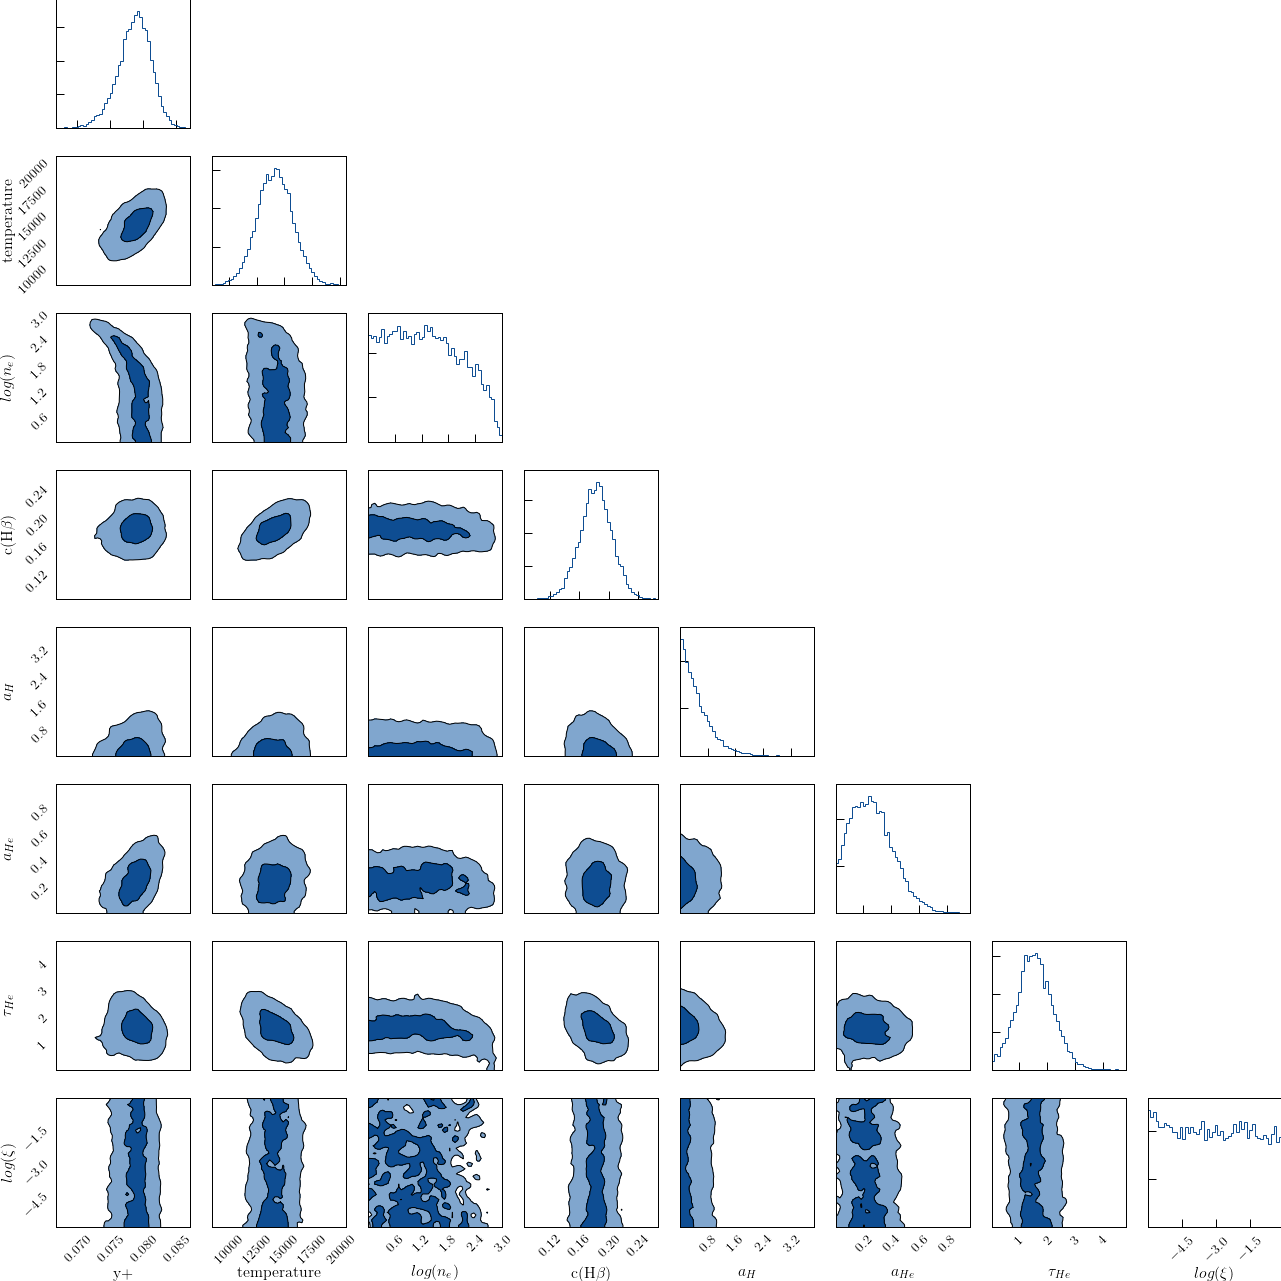

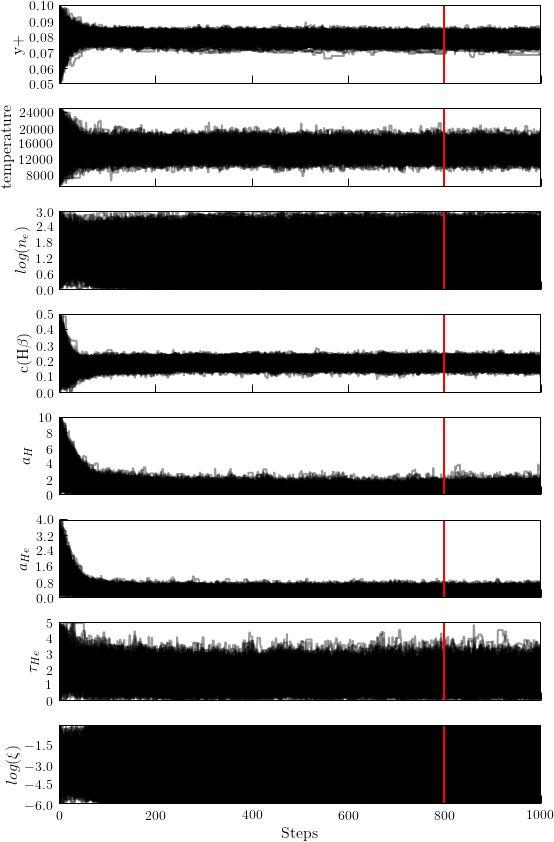

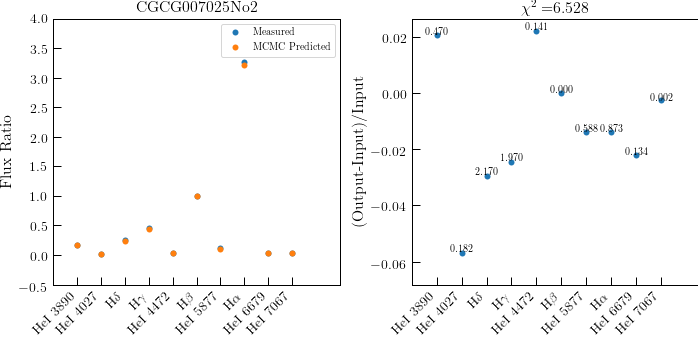

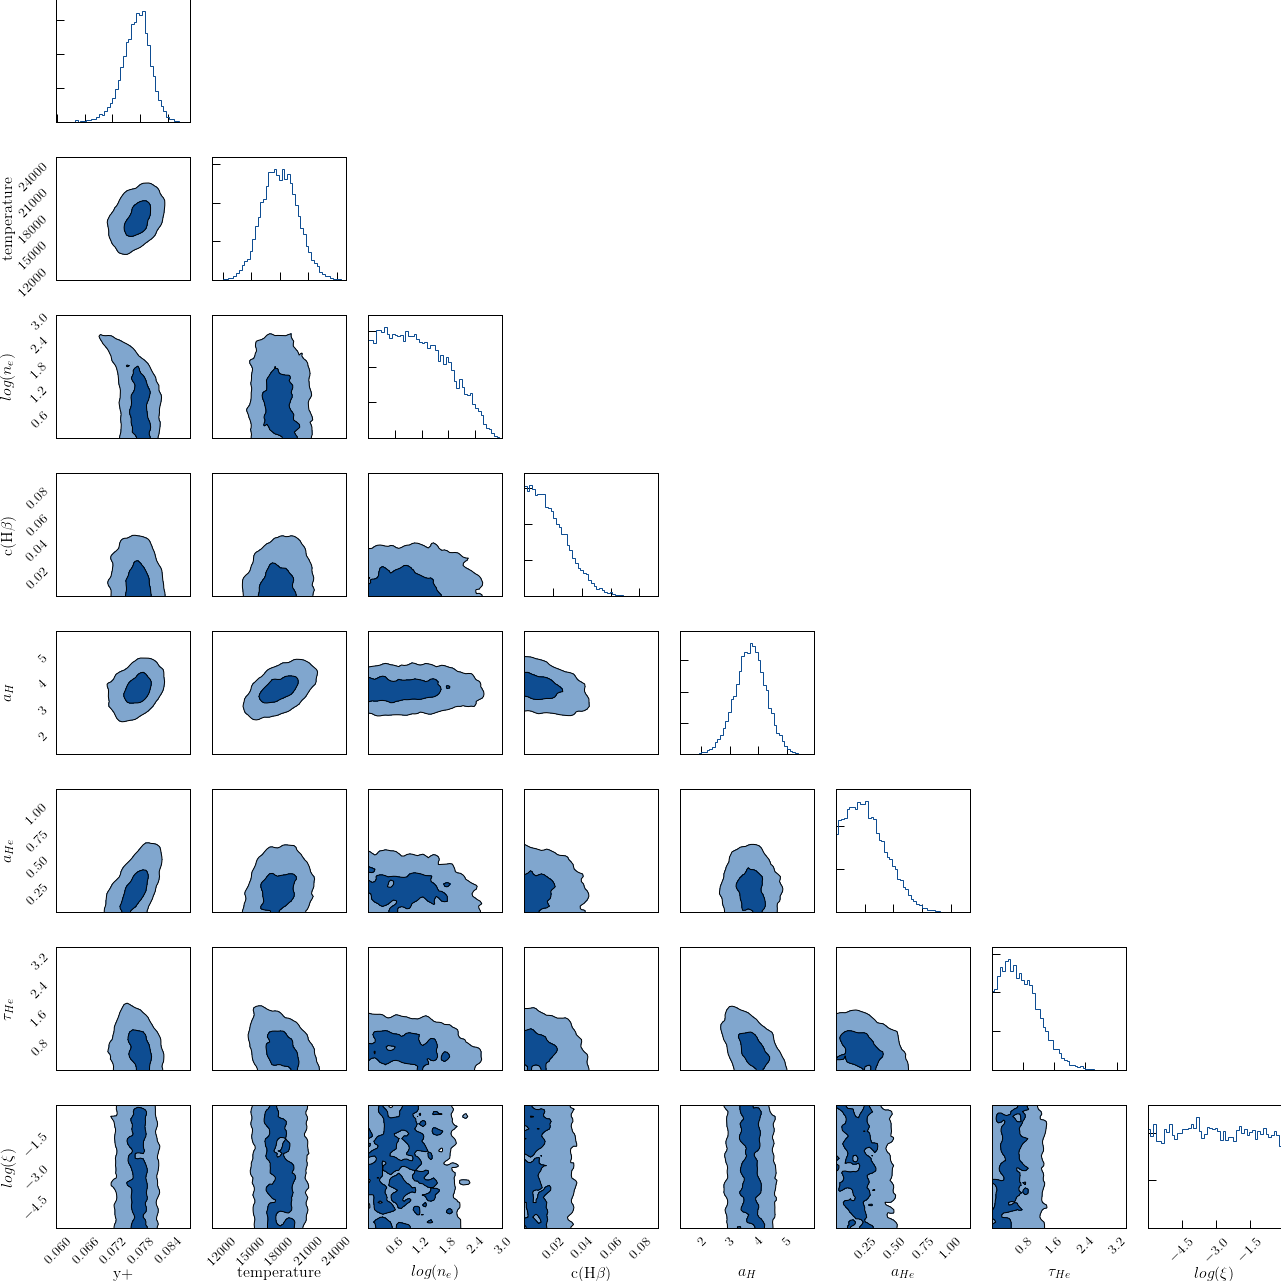

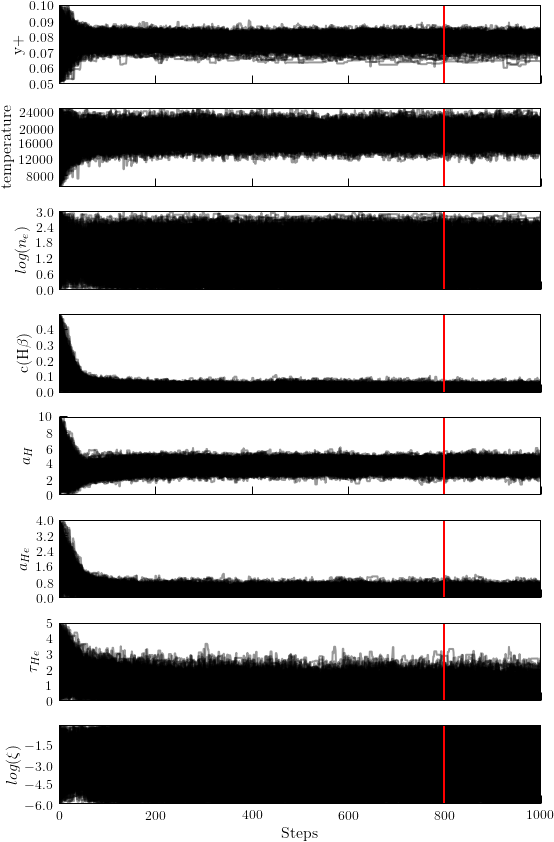

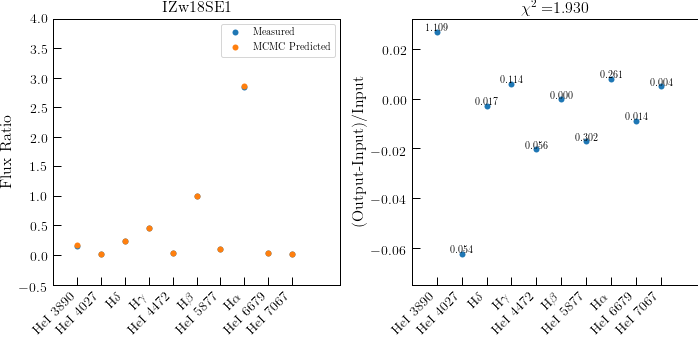

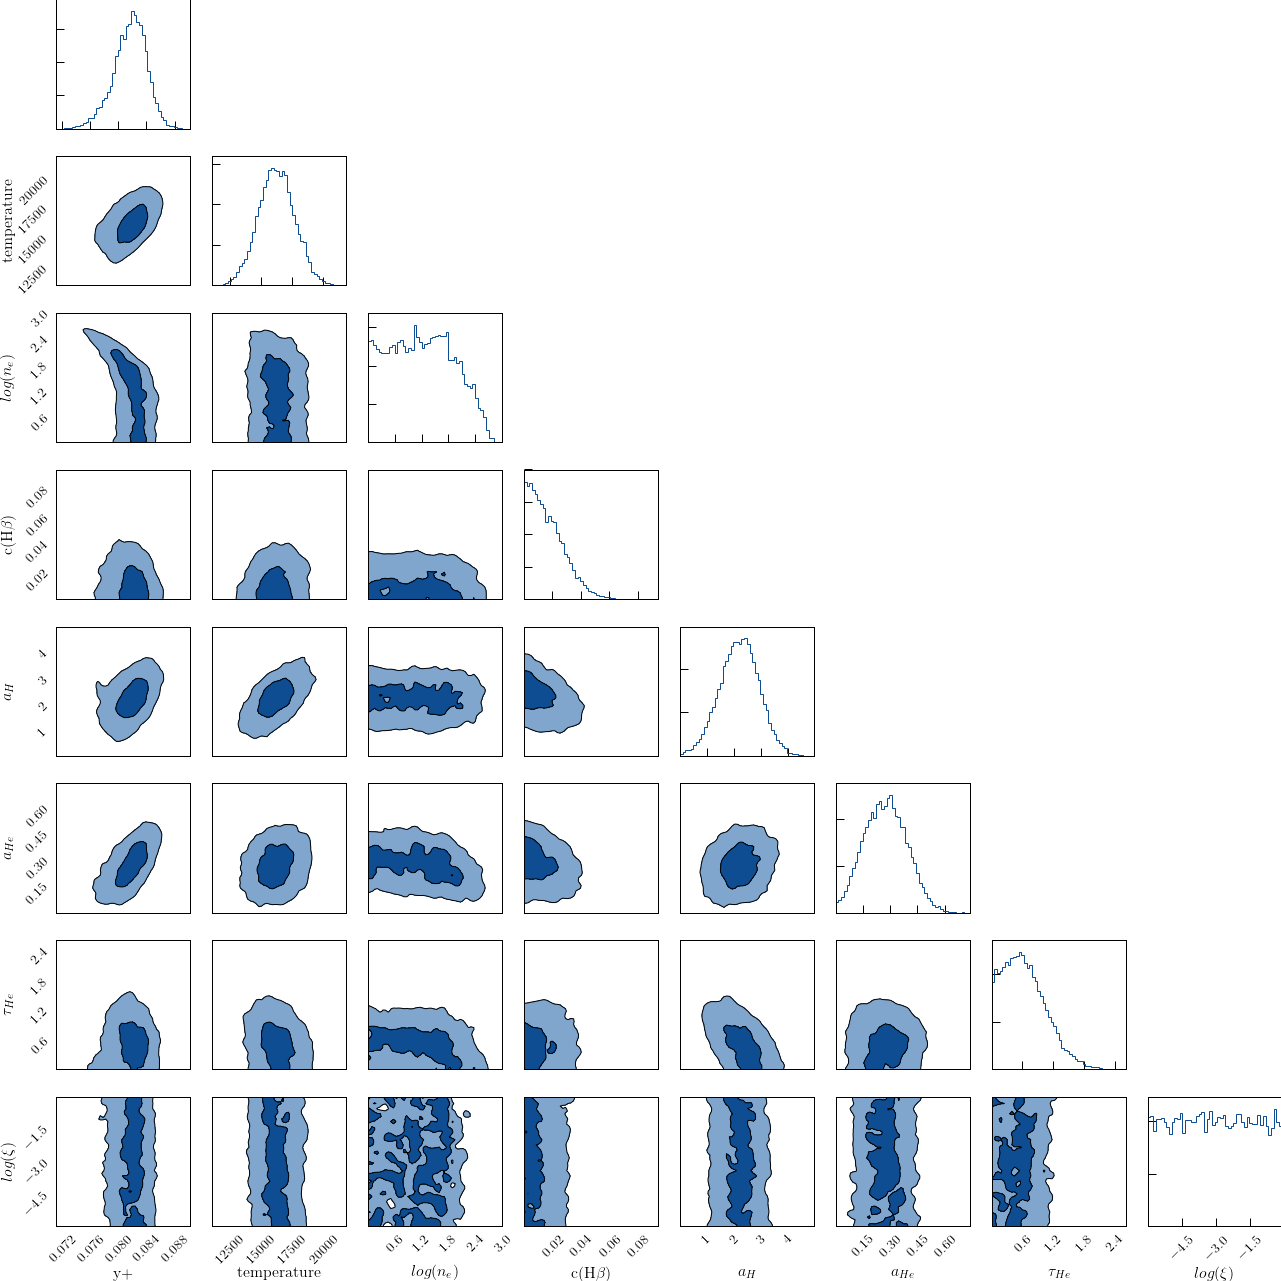

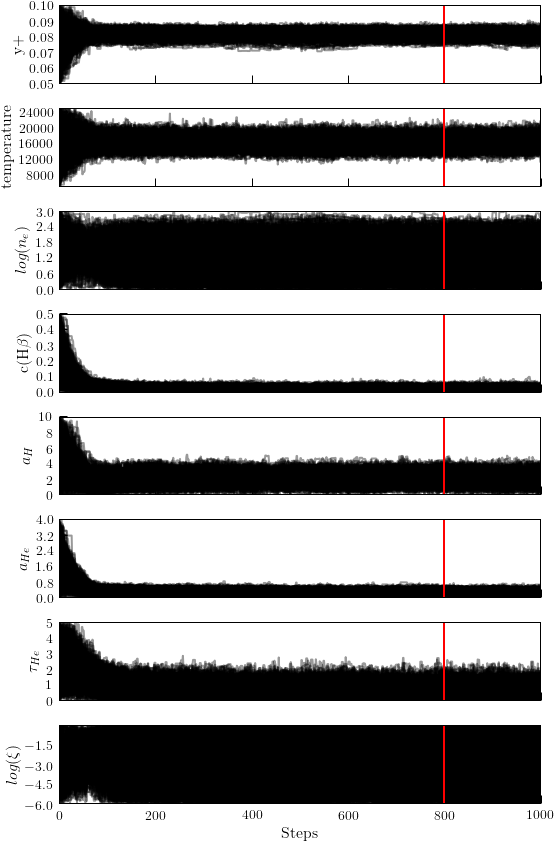

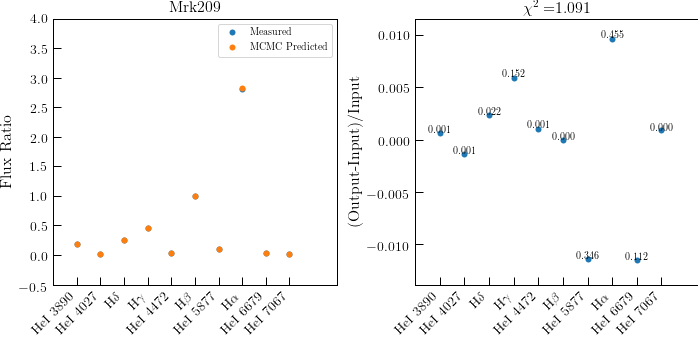

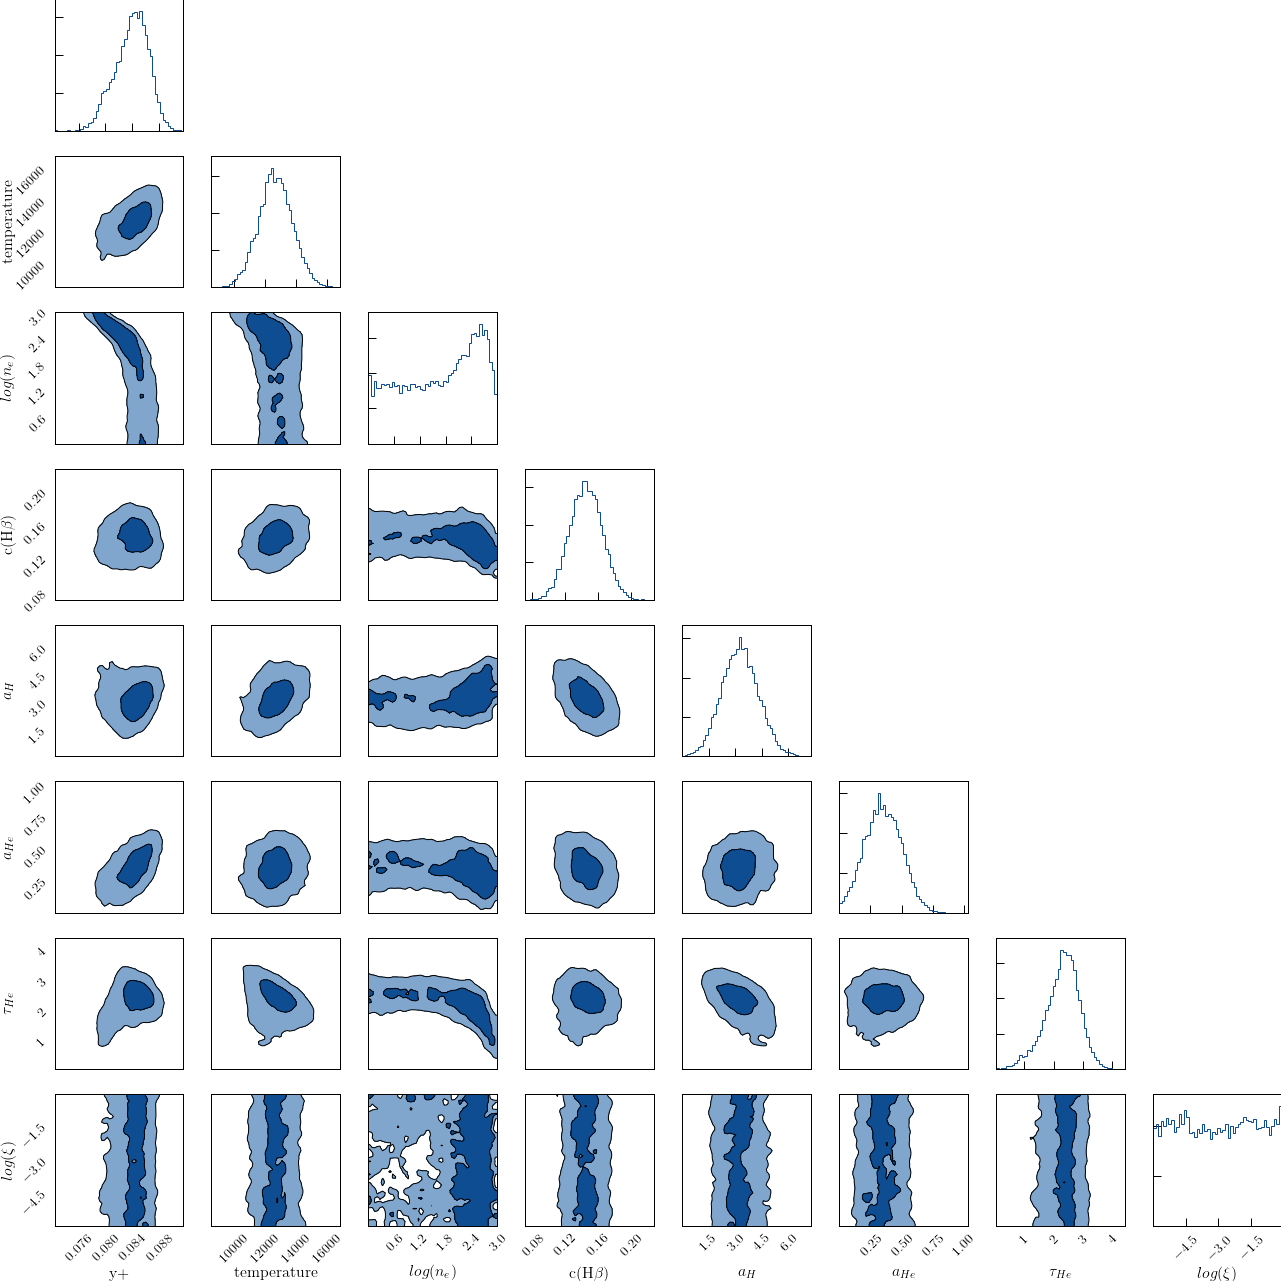

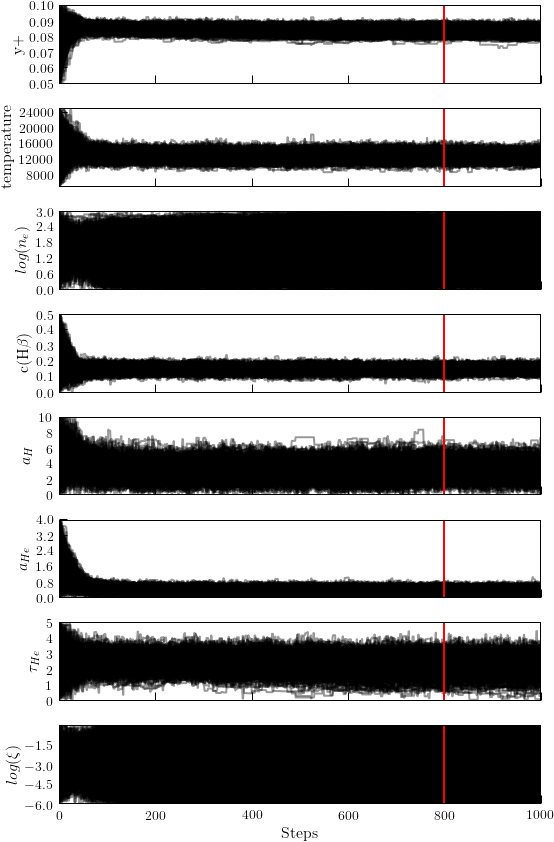

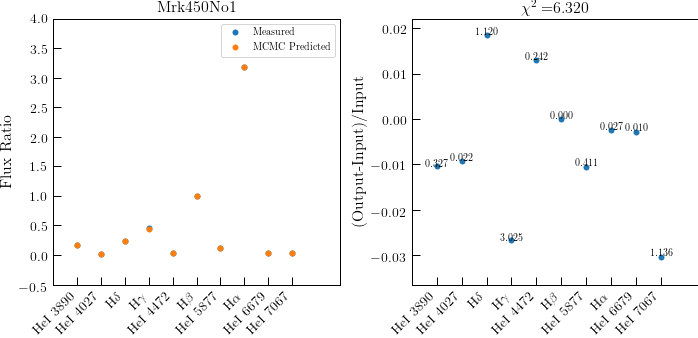

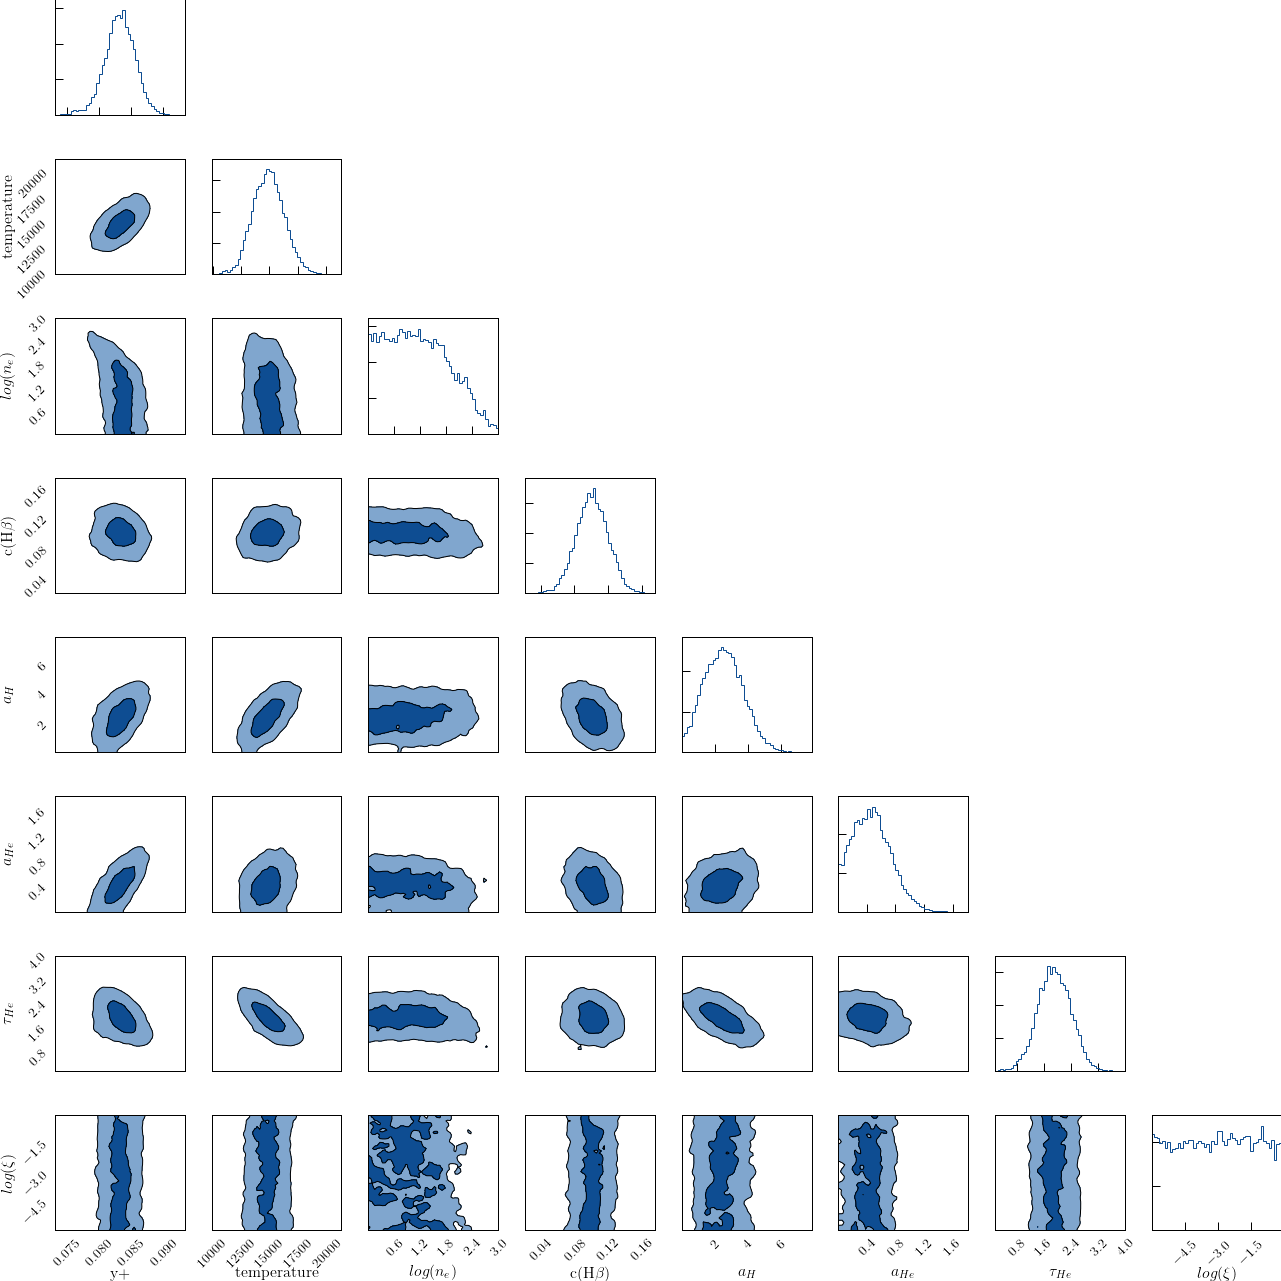

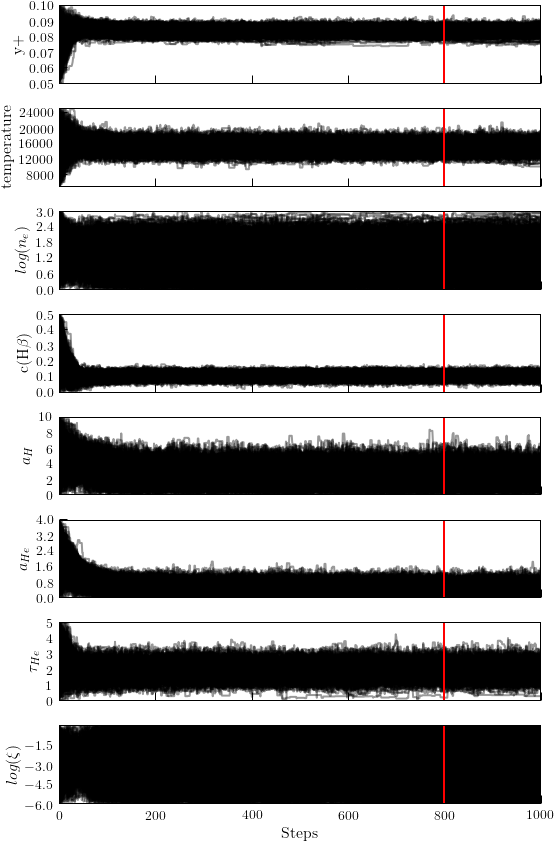

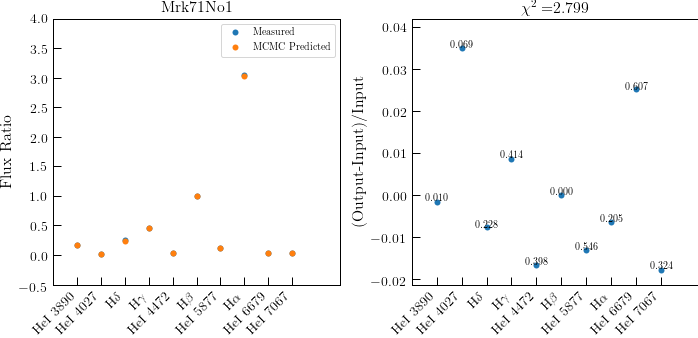

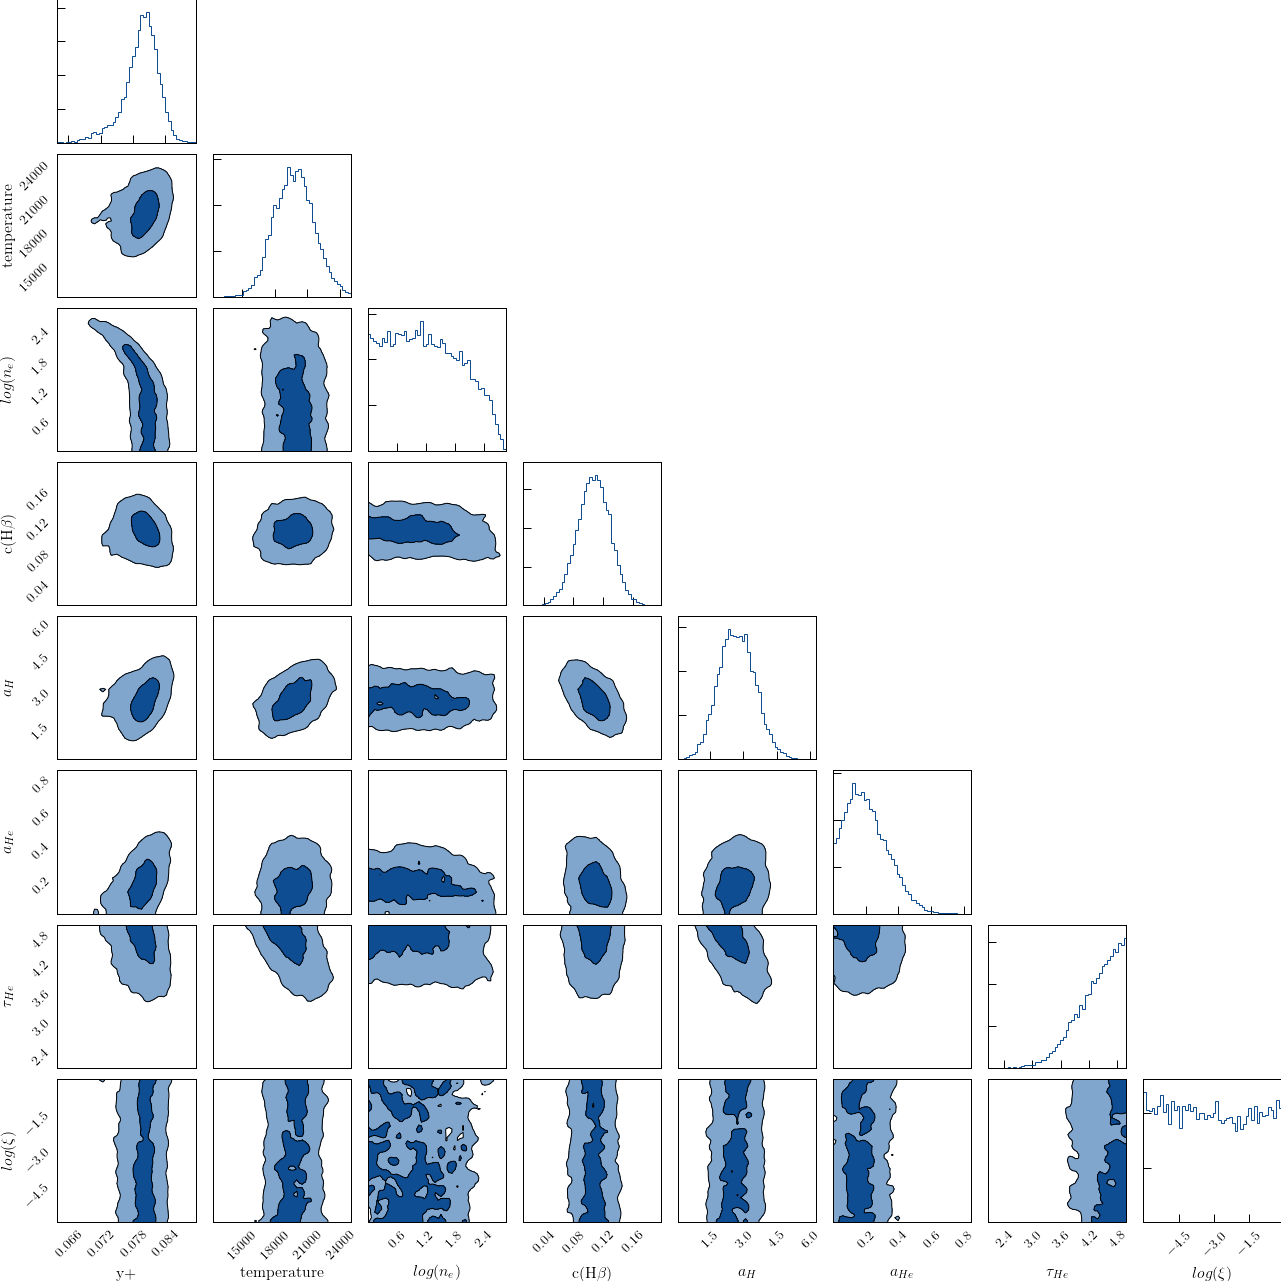

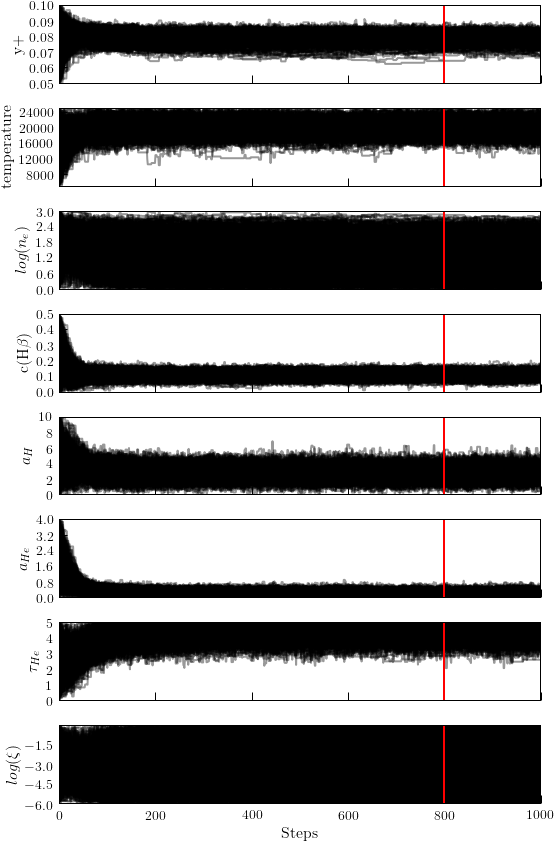

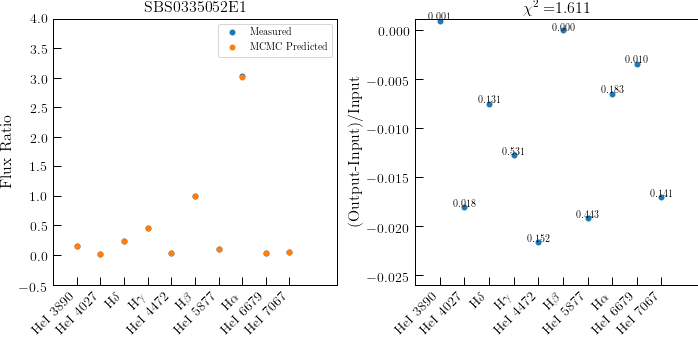

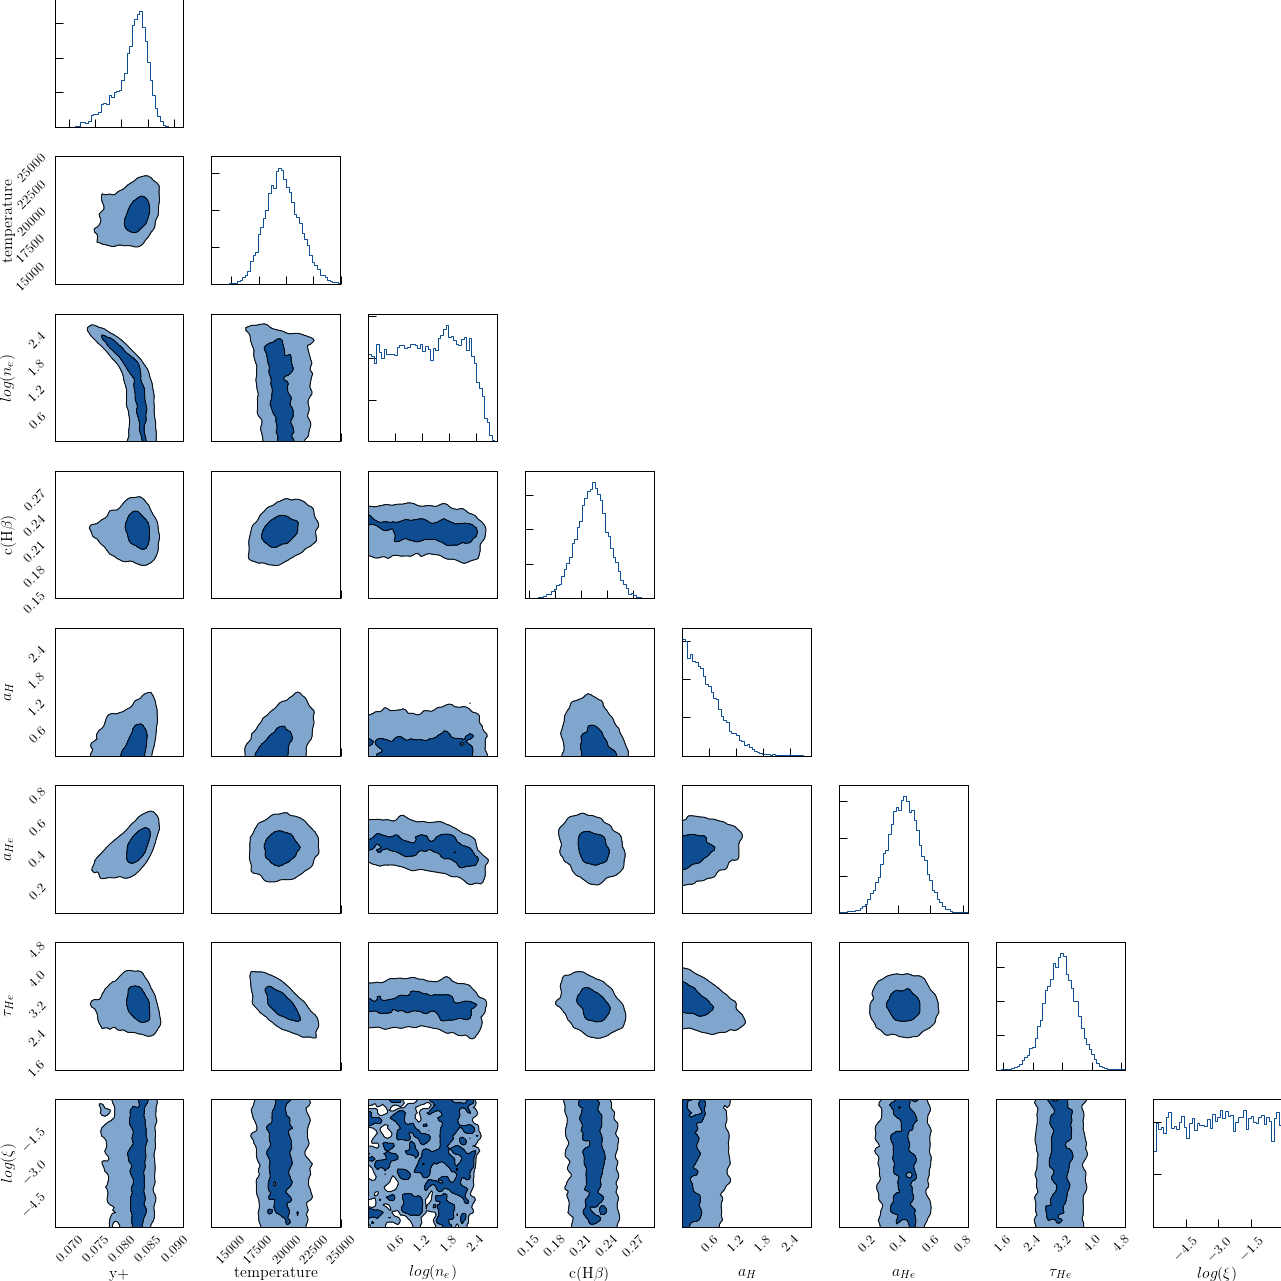

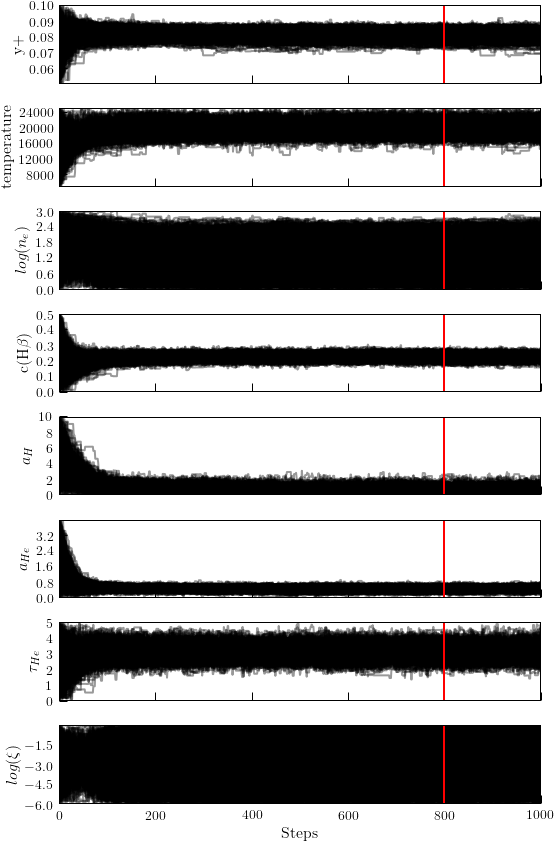

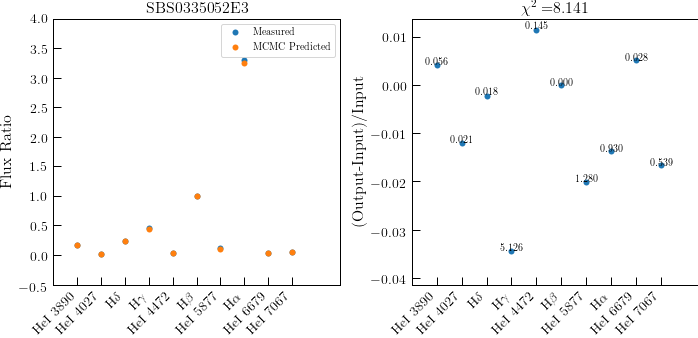

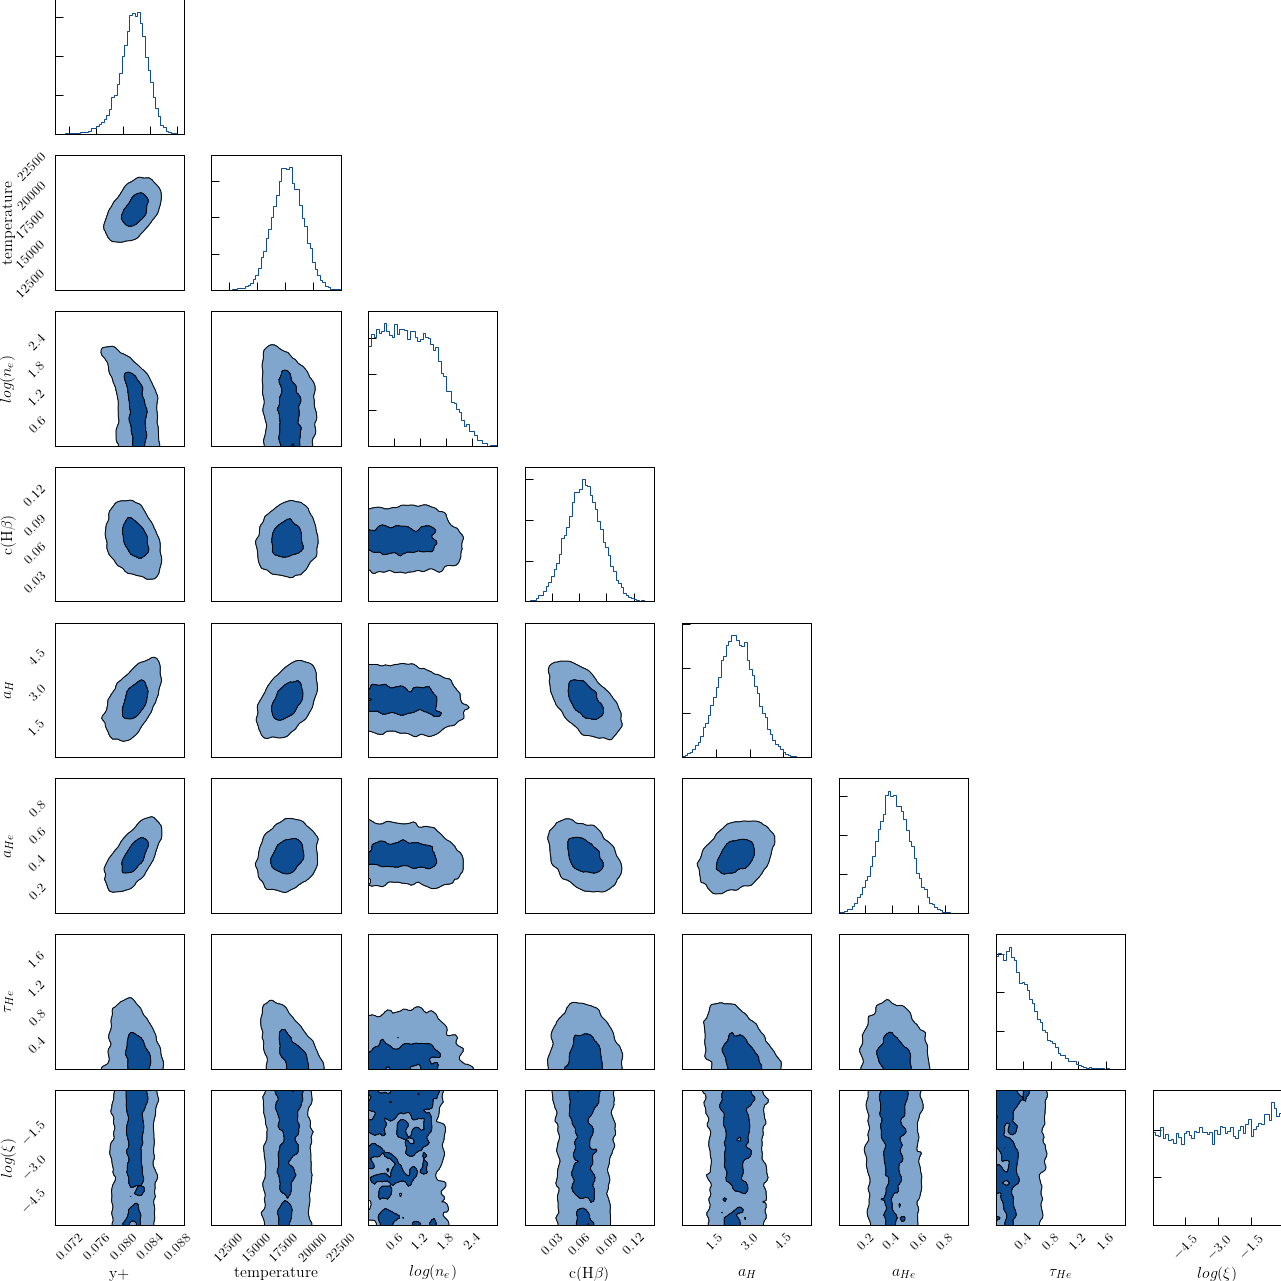

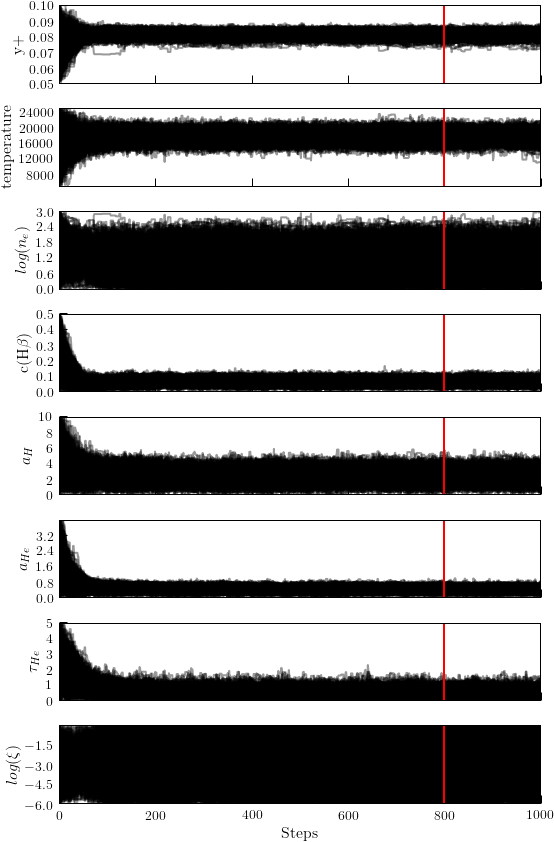

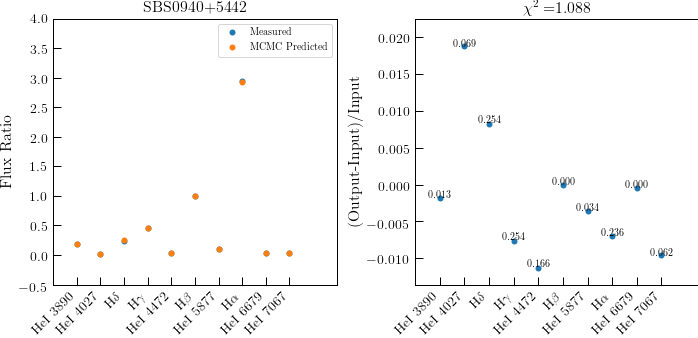

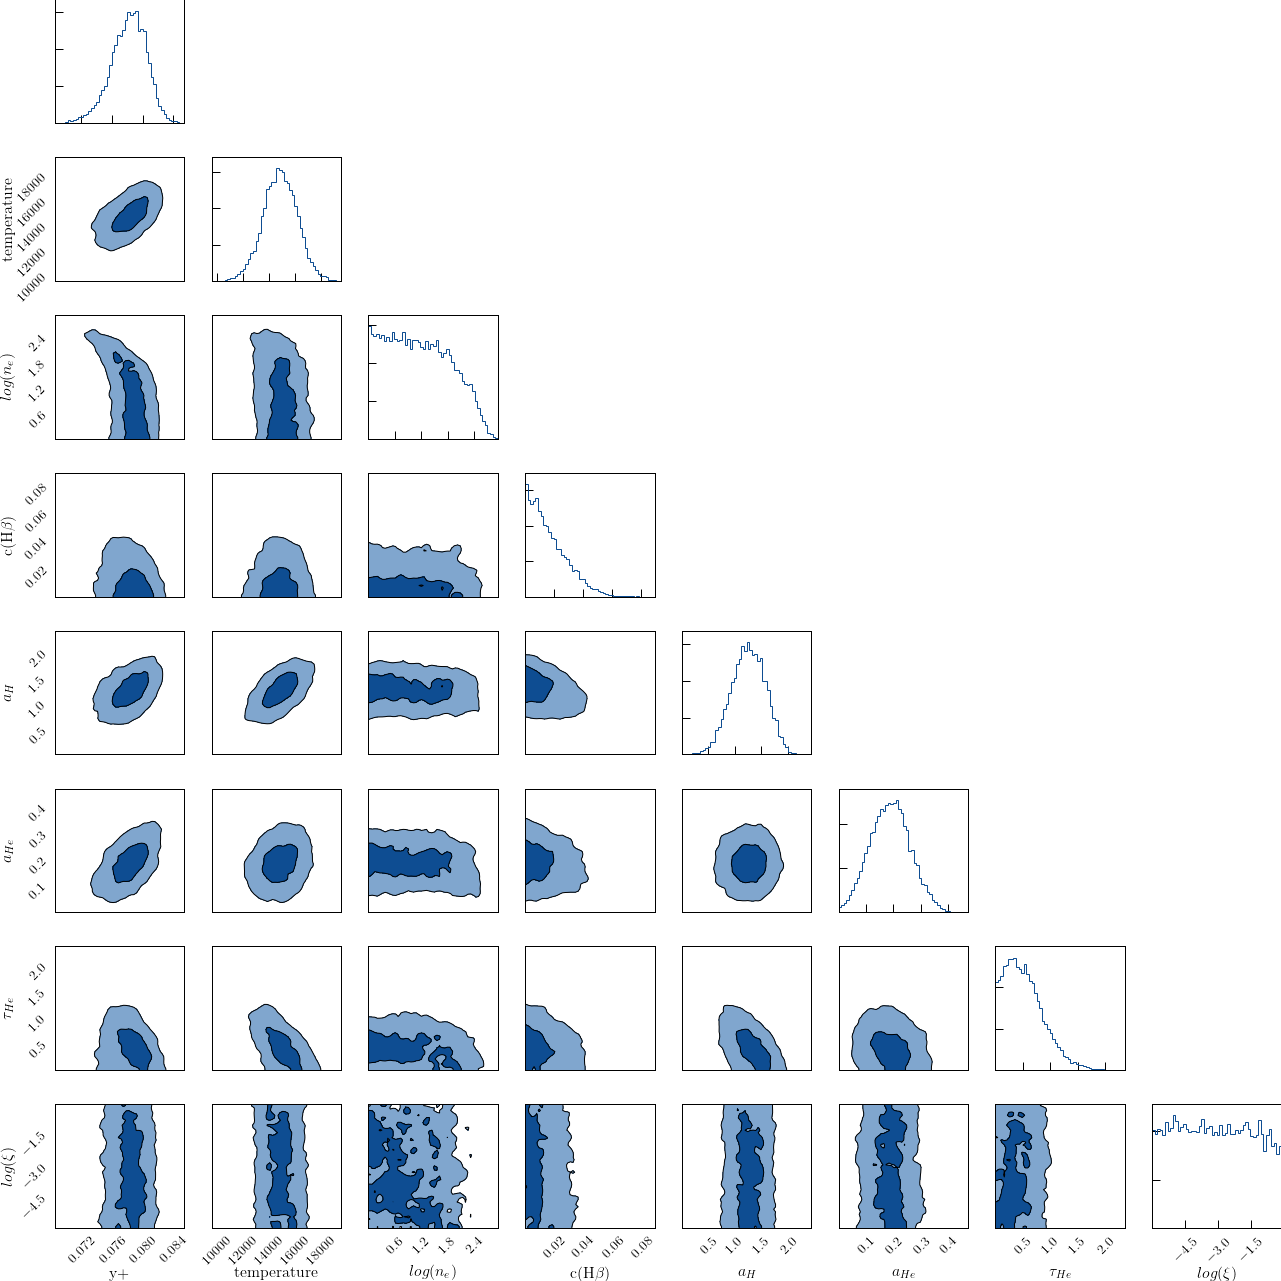

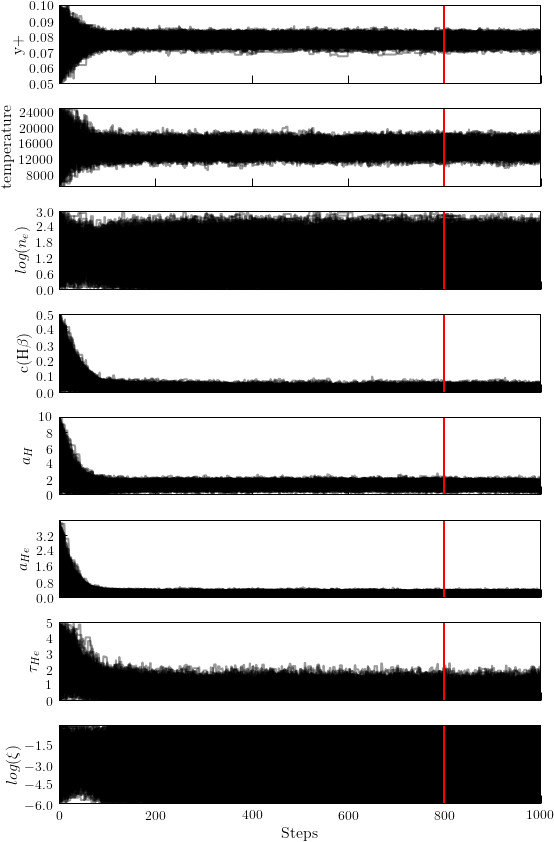

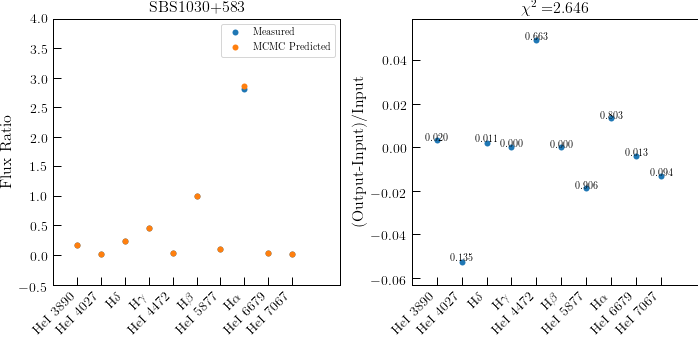

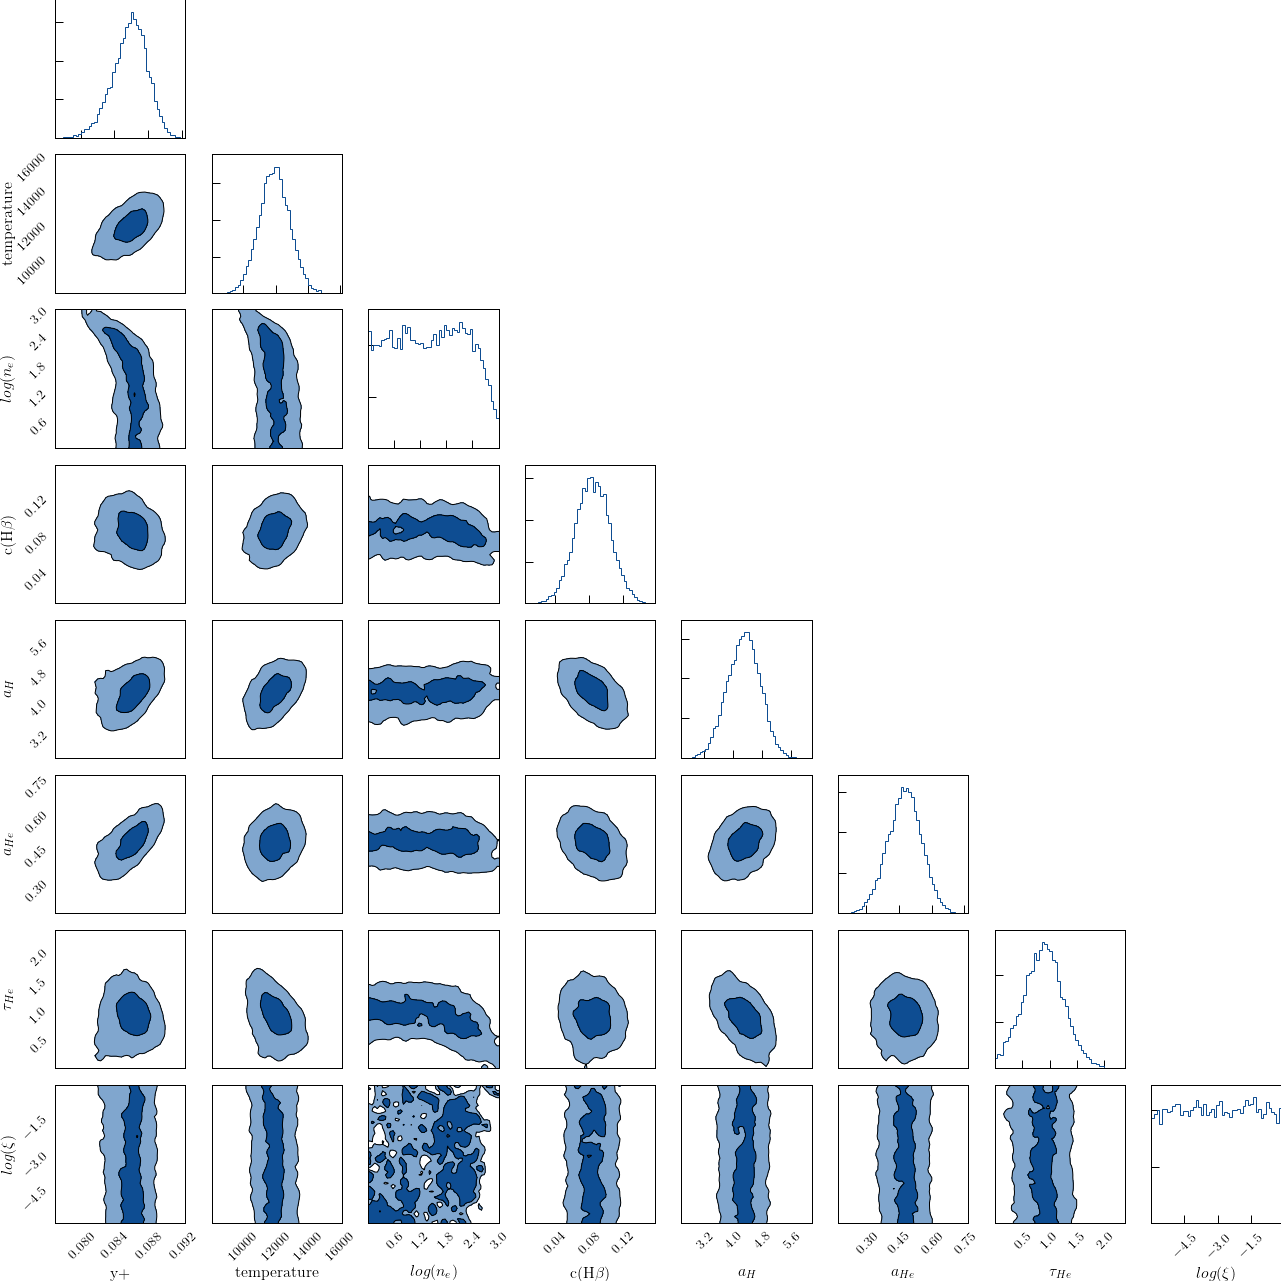

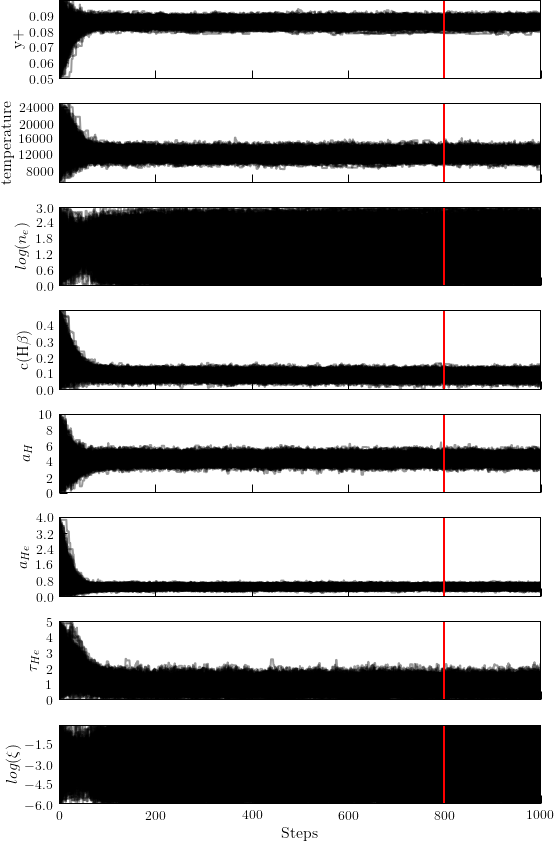

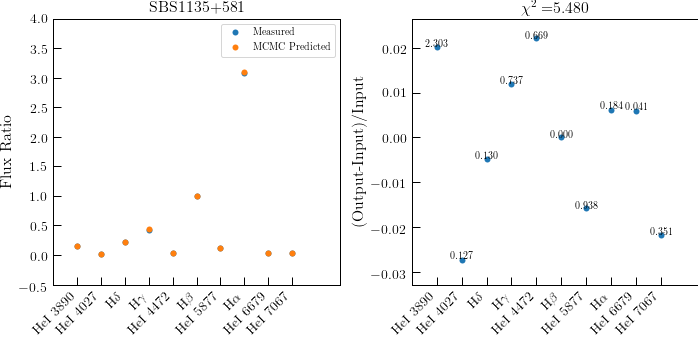

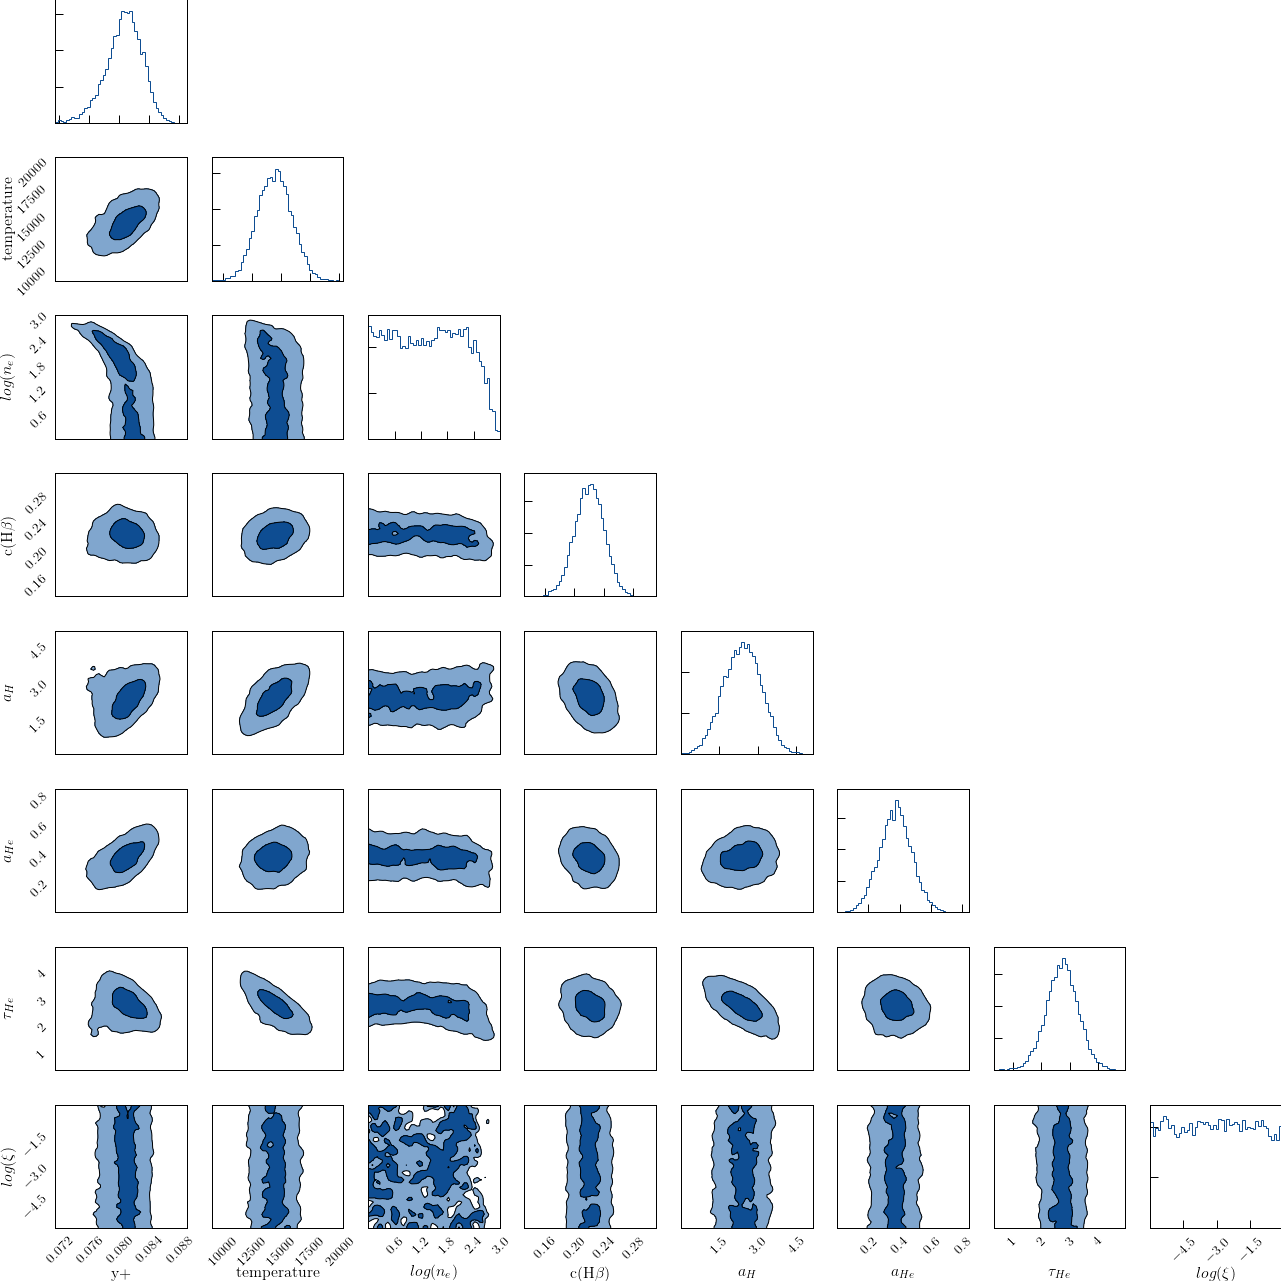

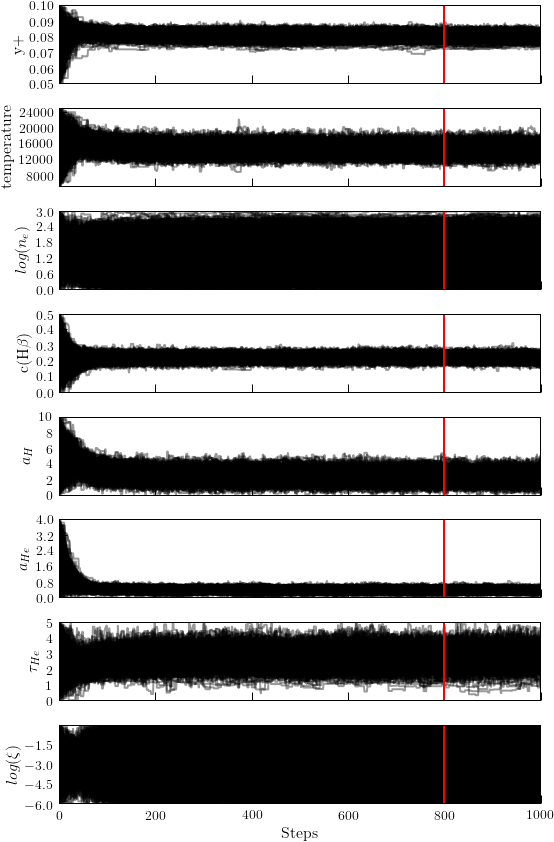

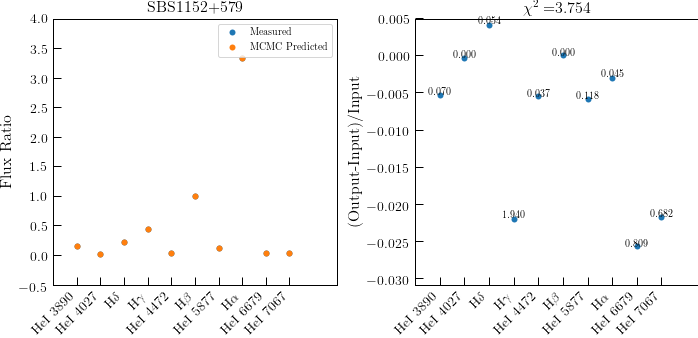

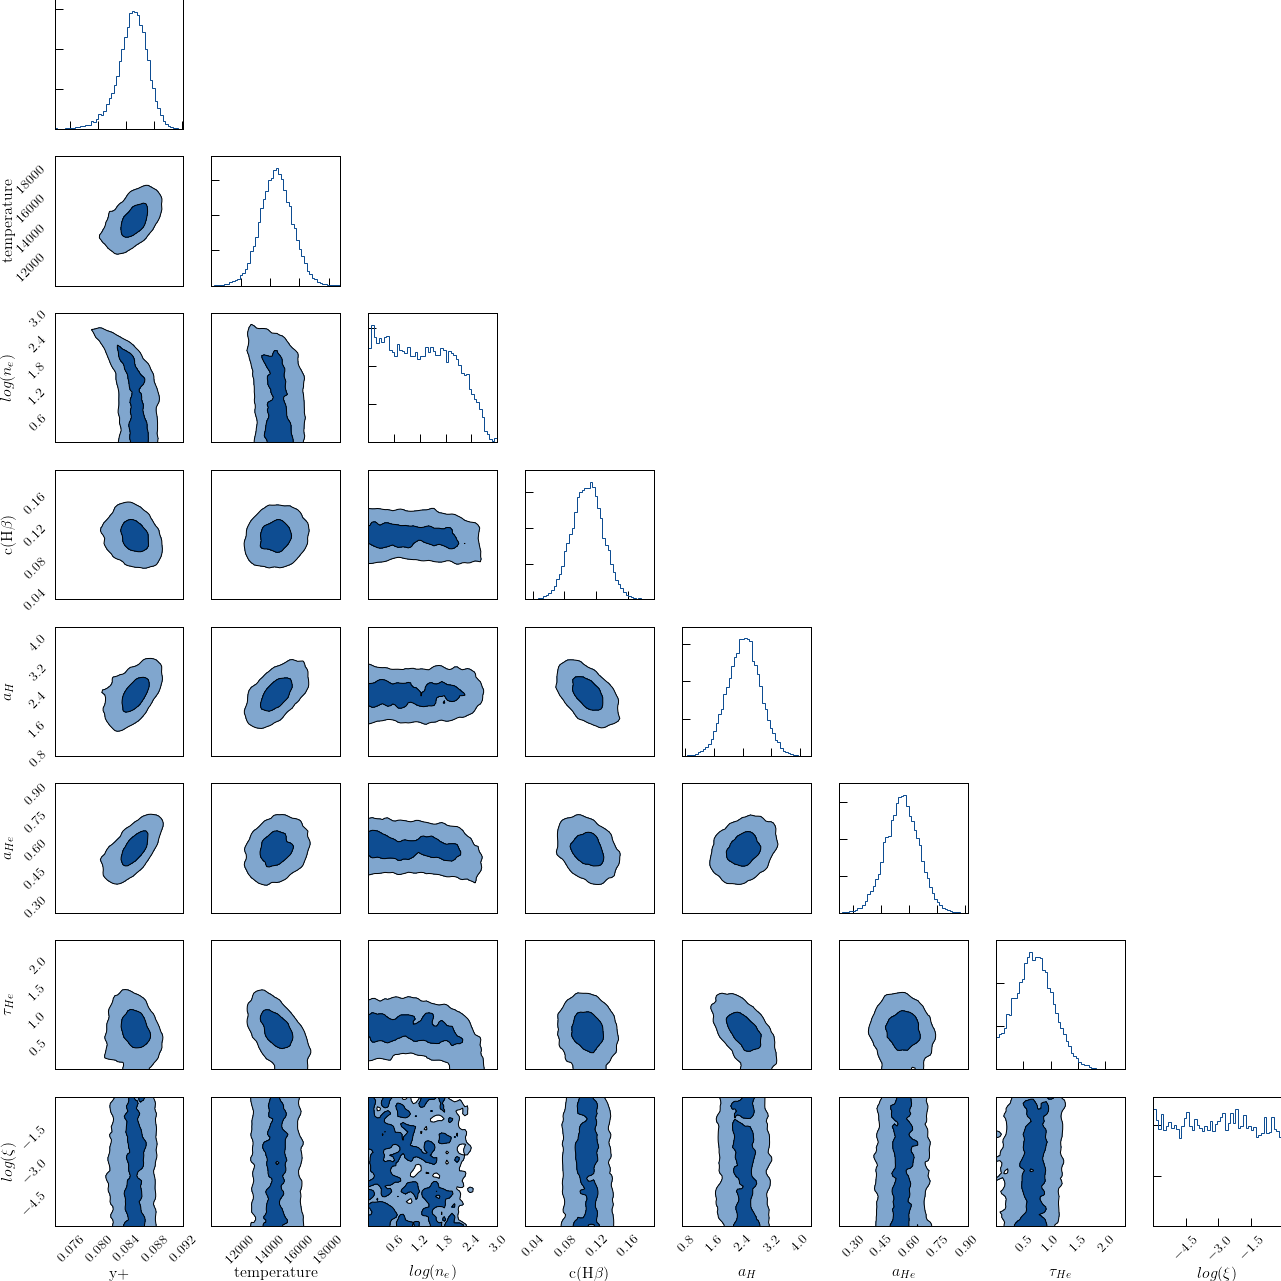

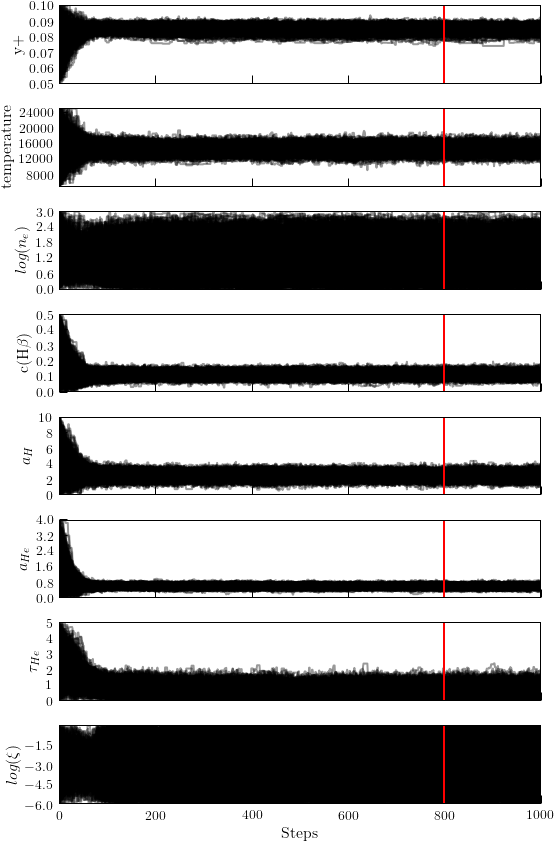

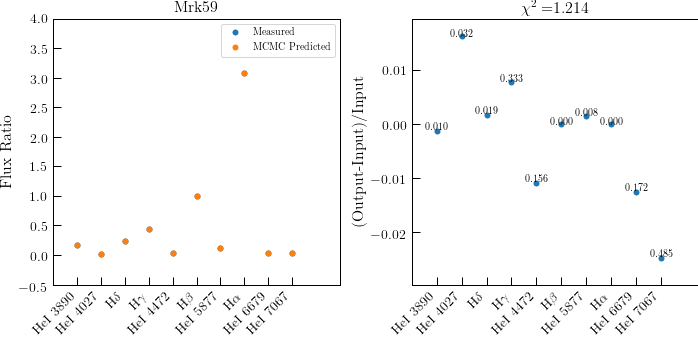

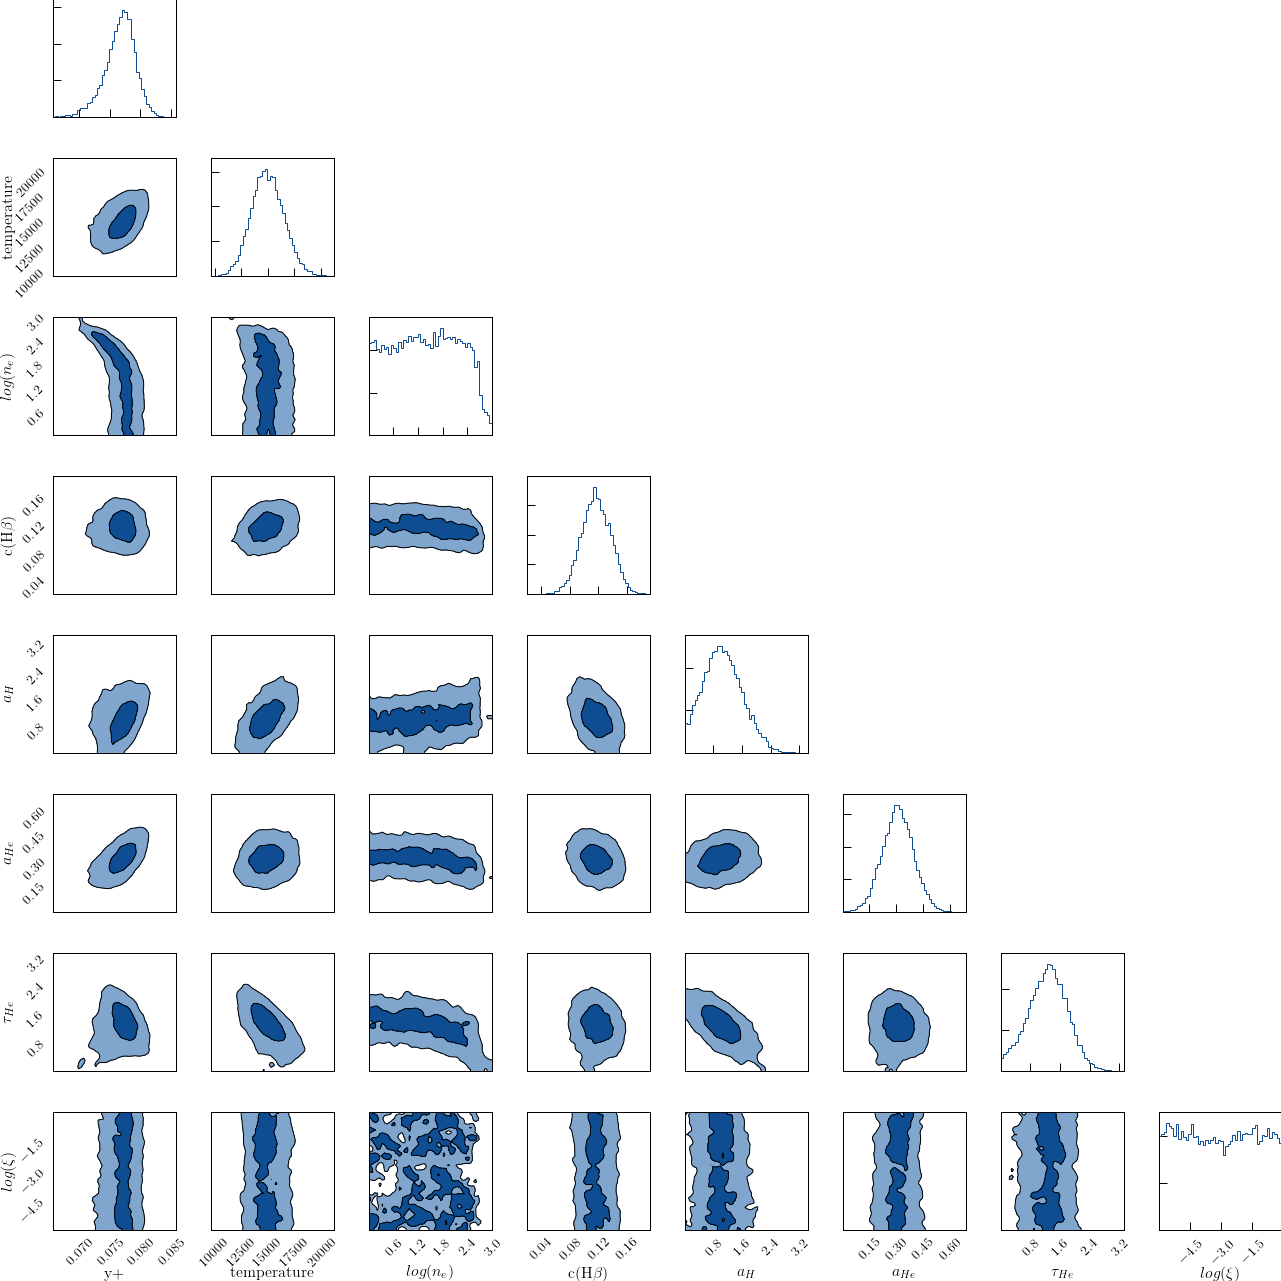

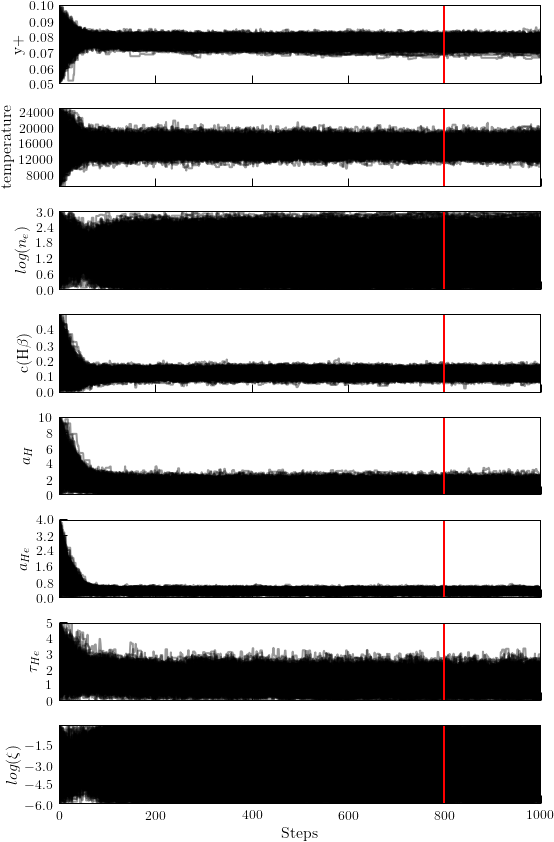

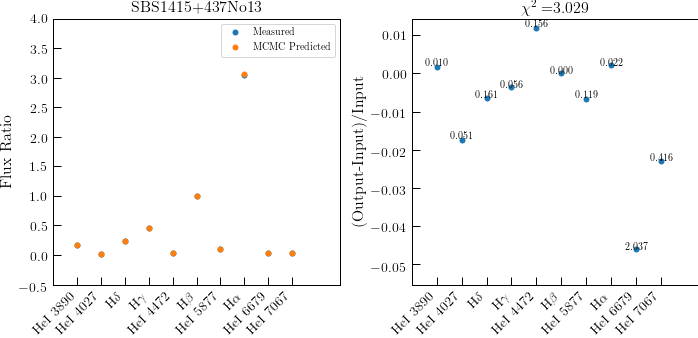

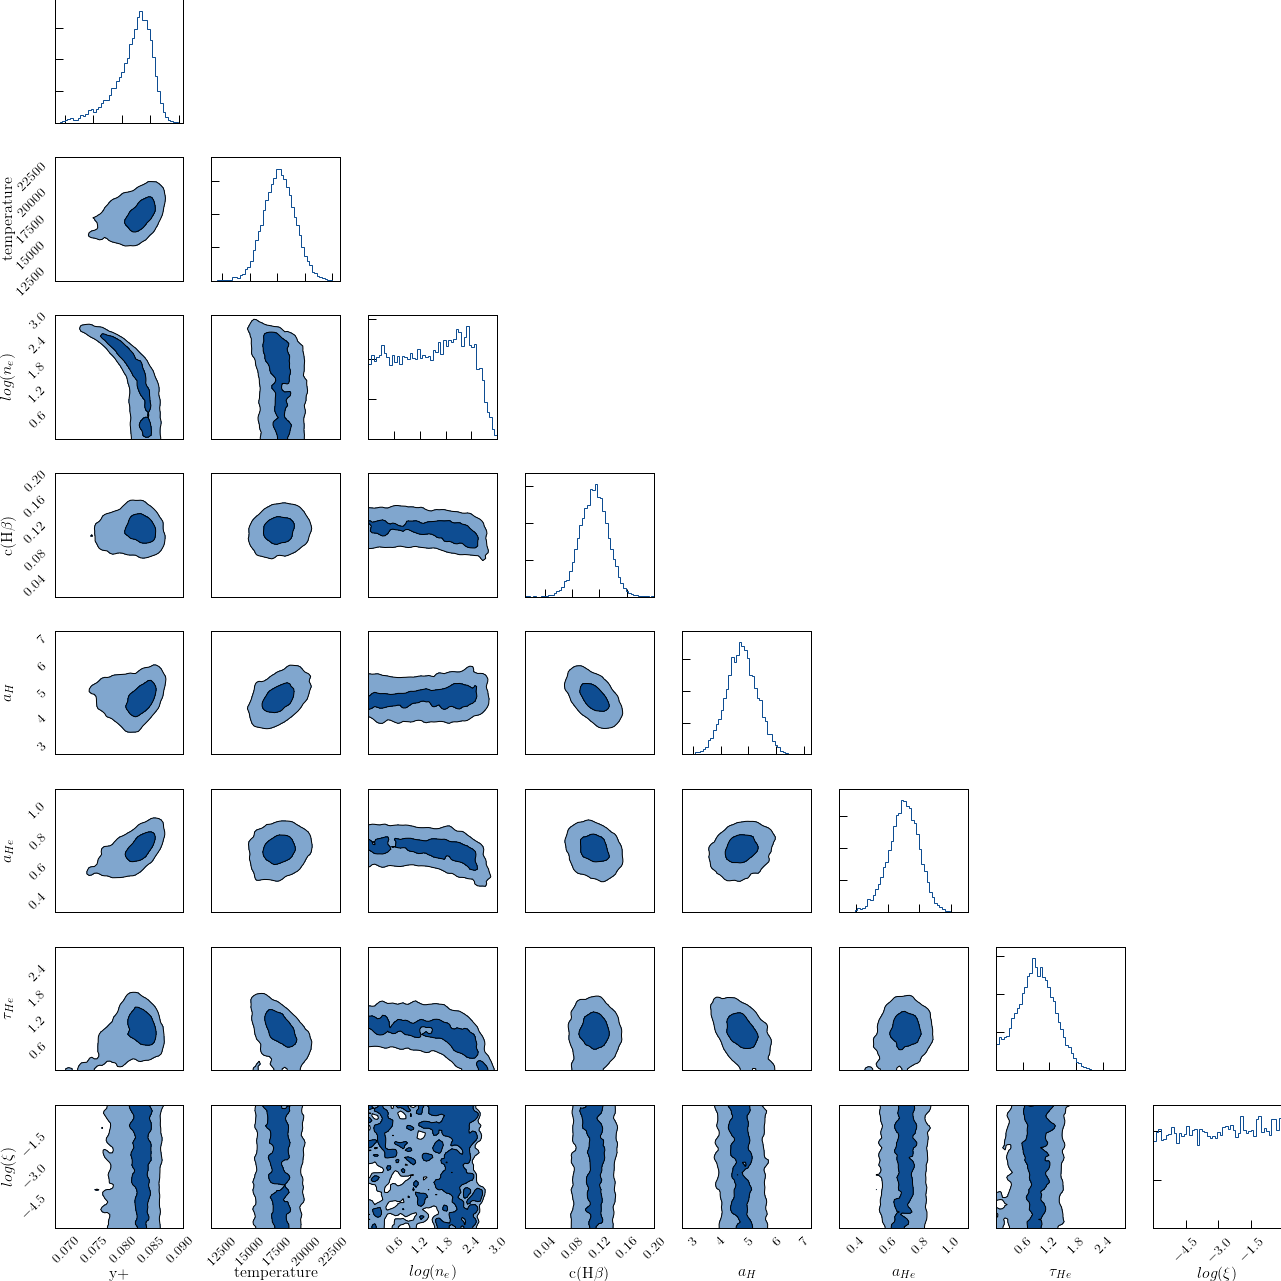

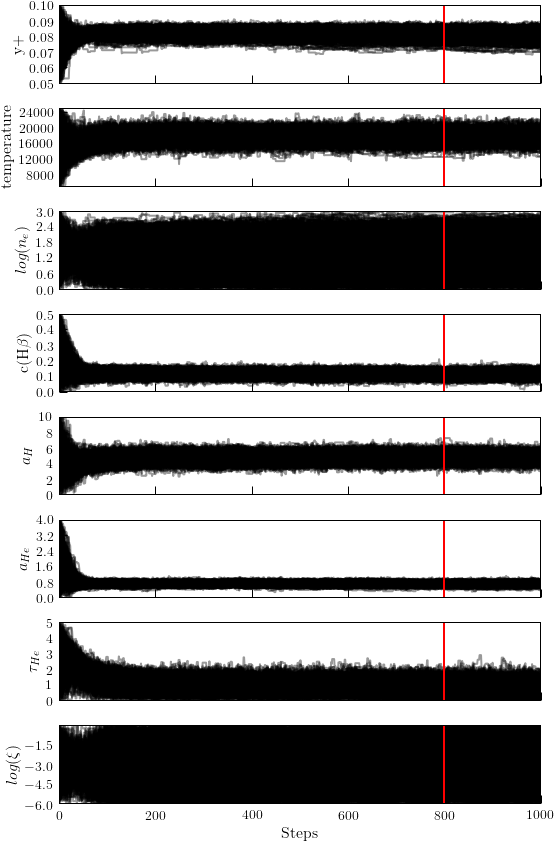

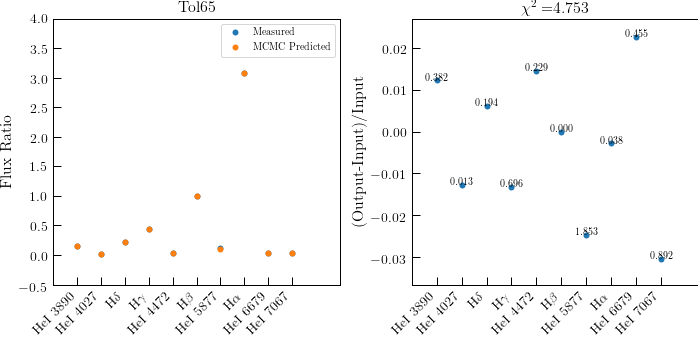

In [45]:
chisq = np.zeros((len(qualifying), 10)) # 10 is number of emission lines used in analysis
# Also equal to len(input_vals) which comes on later in this block

for npy in range(len(qualifying)):
    name = str(qualifying[npy].replace(' ', '').replace('(','').replace('-', '').replace(')','').replace('.', ''))
    
    print (name)
    # Load .npy file
    ndim = 8
    onevar = -1

    nwalkers = 500
    nmbr = 1000
    burnin = int(0.8*nmbr) #int(0.1*nmbr)

    chains = np.load('test_data/'+name+'_500walkers_1000steps.npy')
    samples = chains[:, burnin:, :].reshape((-1, ndim))

    prenams = ['y+', 'temperature', '$log(n_{e})$', 'c(H\\beta)', '$a_{H}$', '$a_{He}$', '$\\tau_{He}', '$log(\\xi)$'] #'$n_{HI}$']

    print ('Best parameter values:')
    y_plus_mcmc, temp_mcmc, log_dens_mcmc, c_Hb_mcmc, a_H_mcmc, a_He_mcmc, tau_He_mcmc, log_xi_mcmc = map(
        lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    print ('y+', y_plus_mcmc)
    print ('T', temp_mcmc)
    print ('log(n_e)', log_dens_mcmc)
    print ('c(Hb)', c_Hb_mcmc)
    print ('a_H', a_H_mcmc)
    print ('a_He', a_He_mcmc)
    print ('tau_He', tau_He_mcmc)
    print ('log(xi)', log_xi_mcmc)
    
    # Save our MCMC parameters into an array
    our_yplus[npy] = y_plus_mcmc
    our_temp[npy] = temp_mcmc
    our_dens[npy] = log_dens_mcmc
    our_cHb[npy] = c_Hb_mcmc
    our_aH[npy] = a_H_mcmc
    our_aHe[npy] = a_He_mcmc
    our_tauHe[npy] = tau_He_mcmc
    our_xi[npy] = log_xi_mcmc

    # Make contour plot
    levels = 1.0 - np.exp(-0.5 * np.arange(1.0, 2.1, 1.0) ** 2)
    contour_kwargs, contourf_kwargs = dict({}), dict({})
    contour_kwargs["linewidths"] = [1.0, 1.0]
    contourf_kwargs["colors"] = ((1, 1, 1), (0.502, 0.651, 0.808), (0.055, 0.302, 0.5727))
    hist_kwargs = dict({})
    hist_kwargs["color"] = contourf_kwargs["colors"][-1]
    fig = corner.corner(samples, bins=[50, 50, 50, 50, 50, 50, 50, 50], levels=levels, plot_datapoints=False, fill_contours=True, smooth=1,
    plot_density=False, contour_kwargs=contour_kwargs, contourf_kwargs=contourf_kwargs, hist_kwargs=hist_kwargs, labels=prenams)#, truths=input_vals)
    fig.savefig('{0:s}_{1:d}walkers_{2:d}steps.pdf'.format('test_data/'+name+'_corner', nwalkers, nmbr), overwrite=True)
    fig.show()
    
    # Make time evolution plot
    fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 12))
    for i in range(ndim):
        axes[i].plot(chains[:, :, i].T, color="k", alpha=0.4)
        axes[i].yaxis.set_major_locator(MaxNLocator(5))
        axes[i].axvline(burnin, color='red')
        axes[i].set_ylabel(prenams[i])
    axes[7].set_xlabel('Steps')
    fig.tight_layout(h_pad=0.0)
    fig.savefig('{0:s}_{1:d}walkers_{2:d}steps.pdf'.format('test_data/'+name+'_timeevol', nwalkers, nmbr), overwrite=True)
    fig.show()
 
    # Compare input versus output emission line flux ratios and their relative errors
    input_vals = Table.read('test_data/'+name, format='ascii', delimiter=' ')

    # Generate emission line ratios based on our MCMC parameters
    mfr.generate_emission_line_ratio('test_data/'+name+'_MCMCoutput', [3890.166, 4027.328, 4102.891, 4341.684, 4472.755, 4862.721, 5877.299, 6564.612, 6679.994, 7067.198], \
            input_vals['EW'], input_vals['EW'][np.where(input_vals['Wavelength']==4862.721)[0]][0], \
            y_plus_mcmc[0], temp_mcmc[0], log_dens_mcmc[0], c_Hb_mcmc[0], a_H_mcmc[0], a_He_mcmc[0], tau_He_mcmc[0], log_xi_mcmc[0])
    
    # Output values
    output_vals = Table.read('test_data/'+name+'_MCMCoutput', format='ascii', delimiter=' ')
    
    for emline in range(len(input_vals['Flux Ratio'])):
        chisq[npy][emline] = ( (output_vals['Flux Ratio'][emline] - input_vals['Flux Ratio'][emline])**2 ) \
                        / (input_vals['Flux Ratio Errors'][emline]**2)
        
    #print (chisq[npy], np.sum(chisq[npy]))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(input_vals['Flux Ratio'], 'o', label='Measured')
    ax1.plot(output_vals['Flux Ratio'], 'o', label='MCMC Predicted')
    ax1.set_xticks(np.arange(0, len(input_vals), 1))
    ax1.set_xticklabels(['HeI 3890', 'HeI 4027', r'H$\delta$', r'H$\gamma$', \
                                                  'HeI 4472', r'H$\beta$', 'HeI 5877', r'H$\alpha$', \
                                                  'HeI 6679', 'HeI 7067'], rotation=45, ha='right')
    ax1.set_xlim(-1, len(input_vals)+1)
    ax1.set_ylim(-0.5, 4.0)
    ax1.set_ylabel('Flux Ratio')
    ax1.legend()
    ax1.set_title(name)

    ax2.plot((output_vals['Flux Ratio']-input_vals['Flux Ratio'])/input_vals['Flux Ratio'], 'o')
    
    for j in range(len(input_vals)):
        ax2.text(j, (output_vals['Flux Ratio'][j]-input_vals['Flux Ratio'][j])/input_vals['Flux Ratio'][j], \
             s='{0:.3f}'.format(np.sum(chisq[npy][j])), horizontalalignment='center')
        
    ax2.set_xticks(np.arange(0, len(input_vals), 1))
    ax2.set_xticklabels(['HeI 3890', 'HeI 4027', r'H$\delta$', r'H$\gamma$', \
                                                  'HeI 4472', r'H$\beta$', 'HeI 5877', r'H$\alpha$', \
                                                  'HeI 6679', 'HeI 7067'], rotation=45, ha='right')
    ax2.set_xlim(-1, len(input_vals)+0.5)
    ax2.set_ylim(1.2*np.min((output_vals['Flux Ratio']-input_vals['Flux Ratio'])/input_vals['Flux Ratio']),
                 1.2*np.max((output_vals['Flux Ratio']-input_vals['Flux Ratio'])/input_vals['Flux Ratio']))
    ax2.set_ylabel('(Output-Input)/Input')
    ax2.set_title(r'$\chi^{2}=$' + '{0:.3f}'.format(np.sum(chisq[npy])))
    f.savefig('test_data/'+name+'_IvsO.pdf', overwrite=True)
    f.show()

## Aver's MCMC Results

In [11]:
aops2013_mcmcout = Table.read('/Users/thsyu/Software/Yp/test_data/aops2013_mcmcoutput', format='ascii', delimiter=' ')
aos2015_mcmcout = Table.read('/Users/thsyu/Software/Yp/test_data/aos2015_mcmcoutput', format='ascii', delimiter=' ')

In [12]:
aos2015_mcmcout[0:3]

<Table length=3>
    Object       y+     y+_p    y+_m    dens ...   xi   xi_p  xi_m   chi2 
    str15     float64 float64 float64  int64 ... int64 int64 int64 float64
------------- ------- ------- -------- ----- ... ----- ----- ----- -------
     IZw18SE1 0.07693 0.00423 -0.00358    65 ...     1    13    -1     0.4
SBS0335-052E1 0.07859 0.00418  -0.0047   154 ...     6    35    -6     0.8
SBS0335-052E3 0.08443 0.00396 -0.00385   138 ...     7    19    -5     4.4

In [13]:
aops2013_mcmcout[0:3]

<Table length=3>
   Object       y+     y+_p    y+_m    dens ...   xi   xi_p  xi_m   chi2 
   str15     float64 float64 float64  int64 ... int64 int64 int64 float64
------------ ------- ------- -------- ----- ... ----- ----- ----- -------
    IZw18SE1 0.07916 0.00413 -0.01133     1 ...     0    31     0     0.3
SBS0940+5442 0.08861 0.00561 -0.00617    52 ...    35   122   -35     0.3
       Tol65 0.08389  0.0081 -0.00516   639 ...   186   663   186     0.8

## System vs y+ (AOS2015 and Ours) Plot

In [83]:
color = cm.jet(np.linspace(0,1,len(qualifying)))

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


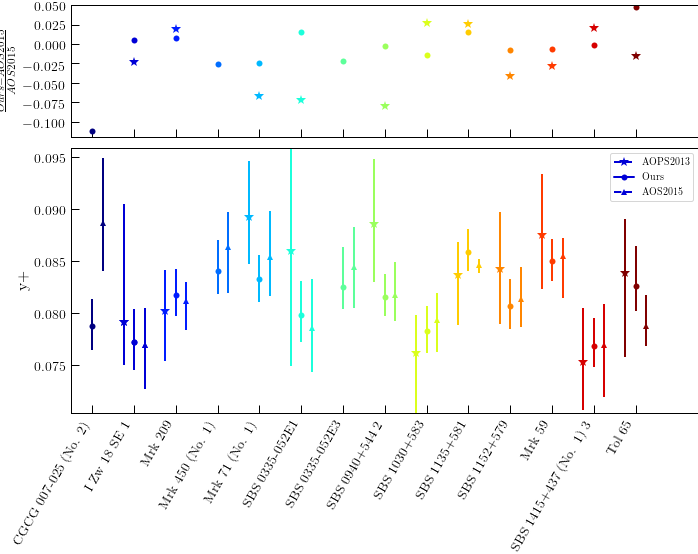

In [95]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
        
    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['y+'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, our_yplus[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['y+'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((our_yplus[obj][0])-(aos2015_mcmcout['y+'][aosidx]))/(aos2015_mcmcout['y+'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, our_yplus[obj][0], yerr = [[our_yplus[obj][1]], [our_yplus[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['y+'][aosidx], yerr=[[aos2015_mcmcout['y+_p'][aosidx]], [-aos2015_mcmcout['y+_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0 :
        ax1.plot(obj, ((our_yplus[obj][0])-(aops2013_mcmcout['y+'][aopsidx]))/(aops2013_mcmcout['y+'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['y+'][aopsidx], yerr=[[aops2013_mcmcout['y+_p'][aopsidx]], [-aops2013_mcmcout['y+_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylim(-0.12, 0.05)
ax1.set_yticks(np.arange(-0.1, 0.05, 0.025))
ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel('y+')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_y+.pdf', overwrite=True)
f.show()

## AOS2015 y+ vs Our y+ plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


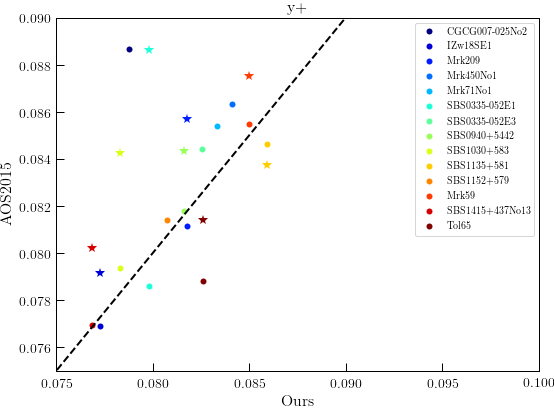

In [94]:
plt.subplots(figsize=(8,6))
x = np.arange(0, 1, 0.1)

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]

    if aopsidx.size != 0:
        plt.plot(our_yplus[obj][0], aops2013_mcmcout['y+'][aosidx], marker='*', markersize=10, color=color[obj], label='_nolabel_')
        
    plt.plot(our_yplus[obj][0], aos2015_mcmcout['y+'][aosidx], 'o', label=name, color=color[obj])

plt.plot(x, x, color='black', ls='--')
plt.xlim(0.075, 0.1)
plt.ylim(0.075, 0.09)
plt.xlabel('Ours')
plt.ylabel('AOS2015')
plt.title('y+')
plt.legend()
plt.savefig('/Users/thsyu/Software/Yp/test_data/y+_vs_y+.pdf', overwrite=True)
plt.show()

## System vs Temperature (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


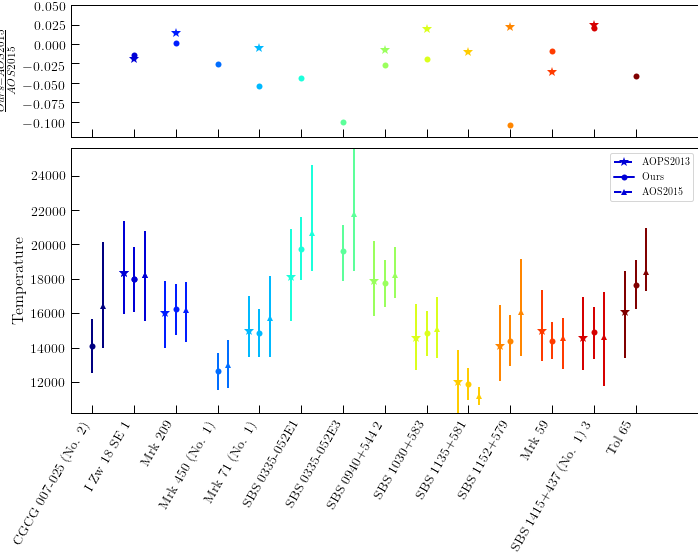

In [122]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
    
    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['temp'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, our_temp[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['temp'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((our_temp[obj][0])-(aos2015_mcmcout['temp'][aosidx]))/(aos2015_mcmcout['temp'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, our_temp[obj][0], yerr = [[our_temp[obj][1]], [our_temp[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['temp'][aosidx], yerr=[[aos2015_mcmcout['temp_p'][aosidx]], [-aos2015_mcmcout['temp_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0:
        ax1.plot(obj, ((our_temp[obj][0])-(aops2013_mcmcout['temp'][aopsidx]))/(aops2013_mcmcout['temp'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['temp'][aopsidx], yerr=[[aops2013_mcmcout['temp_p'][aopsidx]], [-aops2013_mcmcout['temp_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylim(-0.12, 0.05)
ax1.set_yticks(np.arange(-0.1, 0.05, 0.025))
ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel('Temperature')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_temp.pdf', overwrite=True)
f.show()

## System vs Density (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


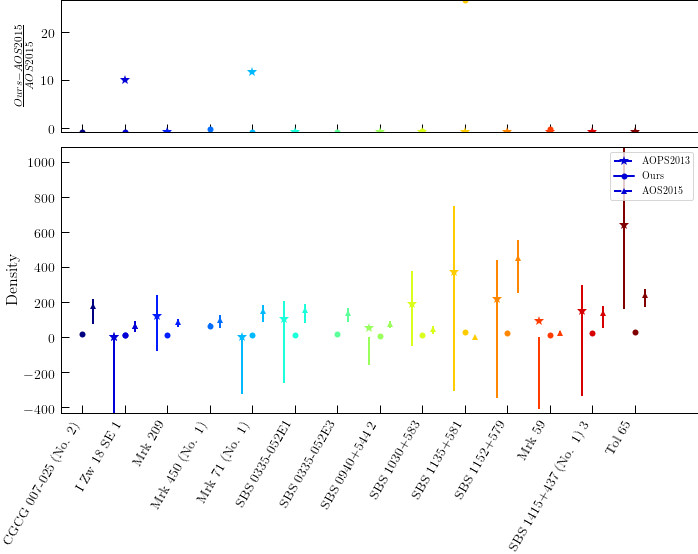

In [101]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]

    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['dens'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, 10**our_dens[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['dens'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((10**our_dens[obj][0])-(aos2015_mcmcout['dens'][aosidx]))/(aos2015_mcmcout['dens'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, 10**our_dens[obj][0], yerr = [[10**our_dens[obj][1]], [10**our_dens[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['dens'][aosidx], yerr=[[aos2015_mcmcout['dens_p'][aosidx]], [-aos2015_mcmcout['dens_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0 :
        ax1.plot(obj, ((10**our_dens[obj][0])-(aops2013_mcmcout['dens'][aopsidx]))/(aops2013_mcmcout['dens'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['dens'][aopsidx], yerr=[[aops2013_mcmcout['dens_p'][aopsidx]], [-aops2013_mcmcout['dens_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

#ax1.set_ylim(-0.12, 0.05)
#ax1.set_yticks(np.arange(-0.1, 0.05, 0.025))
ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel('Density')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_dens.pdf', overwrite=True)
f.show()

## System vs c(Hb) (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


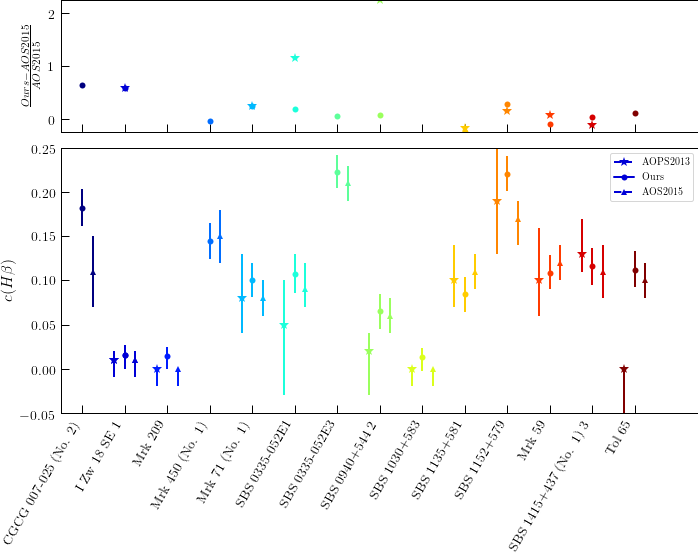

In [123]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
    
    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['cHb'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, our_cHb[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['cHb'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((our_cHb[obj][0])-(aos2015_mcmcout['cHb'][aosidx]))/(aos2015_mcmcout['cHb'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, our_cHb[obj][0], yerr = [[our_cHb[obj][1]], [our_cHb[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['cHb'][aosidx], yerr=[[aos2015_mcmcout['cHb_p'][aosidx]], [-aos2015_mcmcout['cHb_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0:
        ax1.plot(obj, ((our_cHb[obj][0])-(aops2013_mcmcout['cHb'][aopsidx]))/(aops2013_mcmcout['cHb'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['cHb'][aopsidx], yerr=[[aops2013_mcmcout['cHb_p'][aopsidx]], [-aops2013_mcmcout['cHb_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel(r'$c(H\beta)$')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_cHb.pdf', overwrite=True)
f.show()

## System vs a_H (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


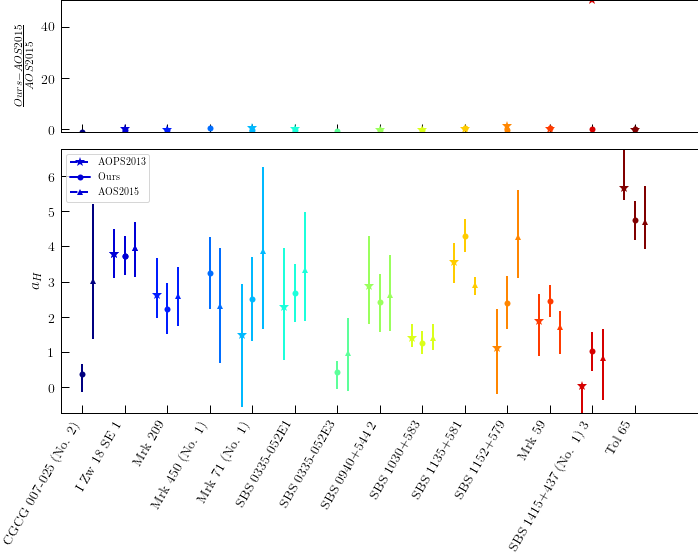

In [108]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
    
    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['aH'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, our_aH[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['aH'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((our_aH[obj][0])-(aos2015_mcmcout['aH'][aosidx]))/(aos2015_mcmcout['aH'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, our_aH[obj][0], yerr = [[our_aH[obj][1]], [our_aH[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['aH'][aosidx], yerr=[[aos2015_mcmcout['aH_p'][aosidx]], [-aos2015_mcmcout['aH_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0:
        ax1.plot(obj, ((our_aH[obj][0])-(aops2013_mcmcout['aH'][aopsidx]))/(aops2013_mcmcout['aH'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['aH'][aopsidx], yerr=[[aops2013_mcmcout['aH_p'][aopsidx]], [-aops2013_mcmcout['aH_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel(r'$a_{H}$')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_aH.pdf', overwrite=True)
f.show()

## System vs a_He (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


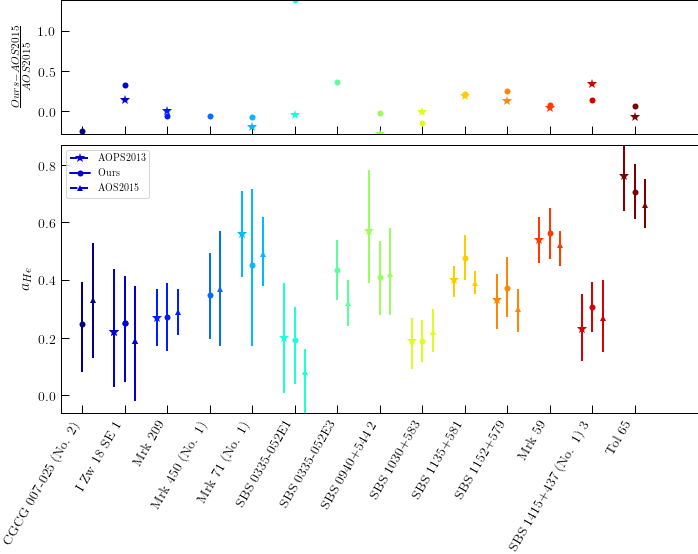

In [109]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
    
    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['aHe'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, our_aHe[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['aHe'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((our_aHe[obj][0])-(aos2015_mcmcout['aHe'][aosidx]))/(aos2015_mcmcout['aHe'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, our_aHe[obj][0], yerr = [[our_aHe[obj][1]], [our_aHe[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['aHe'][aosidx], yerr=[[aos2015_mcmcout['aHe_p'][aosidx]], [-aos2015_mcmcout['aHe_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0:
        ax1.plot(obj, ((our_aHe[obj][0])-(aops2013_mcmcout['aHe'][aopsidx]))/(aops2013_mcmcout['aHe'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['aHe'][aopsidx], yerr=[[aops2013_mcmcout['aHe_p'][aopsidx]], [-aops2013_mcmcout['aHe_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel(r'$a_{He}$')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_aHe.pdf', overwrite=True)
f.show()

## System vs tau_He (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


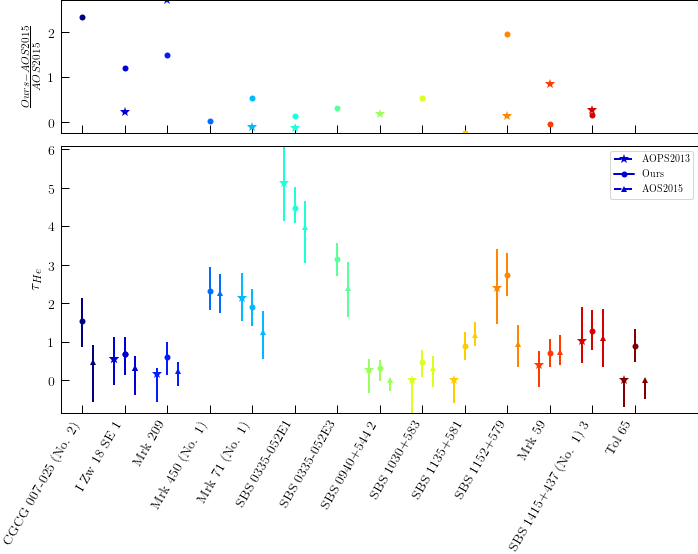

In [110]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
    
    if obj == 1:
        ax2.plot(obj-0.25, aops2013_mcmcout['tauHe'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, our_tauHe[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, aos2015_mcmcout['tauHe'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((our_tauHe[obj][0])-(aos2015_mcmcout['tauHe'][aosidx]))/(aos2015_mcmcout['tauHe'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, our_tauHe[obj][0], yerr = [[our_tauHe[obj][1]], [our_tauHe[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, aos2015_mcmcout['tauHe'][aosidx], yerr=[[aos2015_mcmcout['tauHe_p'][aosidx]], [-aos2015_mcmcout['tauHe_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0:
        ax1.plot(obj, ((our_tauHe[obj][0])-(aops2013_mcmcout['tauHe'][aopsidx]))/(aops2013_mcmcout['tauHe'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, aops2013_mcmcout['tauHe'][aopsidx], yerr=[[aops2013_mcmcout['tauHe_p'][aopsidx]], [-aops2013_mcmcout['tauHe_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
ax2.set_ylabel(r'$\tau_{He}$')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_tauHe.pdf', overwrite=True)
f.show()

## System vs xi (AOS2015 and Ours) Plot

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


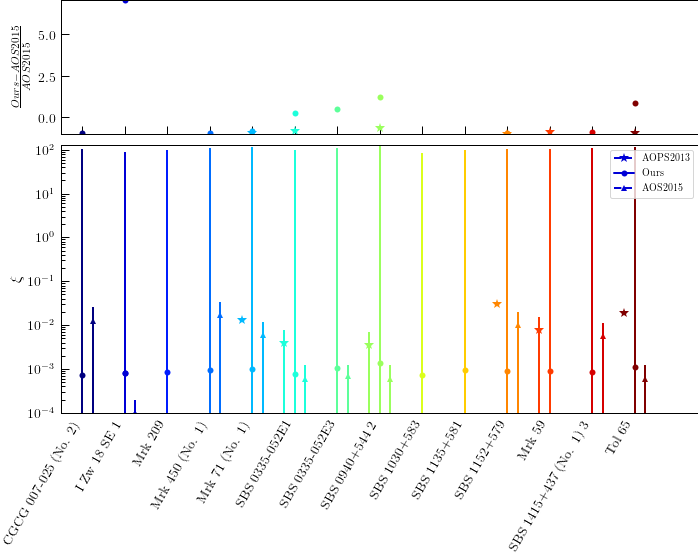

In [120]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw = {'height_ratios':[1.5,3]})
color = cm.jet(np.linspace(0,1,len(qualifying)))

for obj in range(len(qualifying)):
    name = str(qualifying[obj].replace(' ', '').replace('(','').replace(')','').replace('.', ''))
    aosidx = np.where(aos2015_mcmcout['Object'] == name)[0]
    aopsidx = np.where(aops2013_mcmcout['Object'] == name)[0]
    
    if obj == 1:
        ax2.plot(obj-0.25, 1e-4*aops2013_mcmcout['xi'][aopsidx], marker='*', markersize=10, ls='--', color=color[obj], label='AOPS2013')
        ax2.plot(obj, 10**our_xi[obj][0], marker='o', color=color[obj], label='Ours')
        ax2.plot(obj+0.25, 1e-4*aos2015_mcmcout['xi'][aosidx], marker='^', ls='--', color=color[obj], label='AOS2015')
    
    ax1.plot(obj, ((10**our_xi[obj][0])-(1e-4*aos2015_mcmcout['xi'][aosidx]))/(1e-4*aos2015_mcmcout['xi'][aosidx]), marker='o', color=color[obj], label='_nolabel')
    ax2.errorbar(obj, 10**our_xi[obj][0], yerr = [[10**our_xi[obj][1]], [10**our_xi[obj][2]]], marker='o', color=color[obj], label='_nolabel_')
    ax2.errorbar(obj+0.25, 1e-4*aos2015_mcmcout['xi'][aosidx], yerr=[[1e-4*aos2015_mcmcout['xi_p'][aosidx]], [-1e-4*aos2015_mcmcout['xi_m'][aosidx]]], marker='^', ls='--', color=color[obj], label='_nolabel_')

    if aopsidx.size != 0:
        ax1.plot(obj, ((10**our_xi[obj][0])-(1e-4*aops2013_mcmcout['xi'][aopsidx]))/(1e-4*aops2013_mcmcout['xi'][aopsidx]), marker='*', markersize=10, color=color[obj], label='_nolabel')
        ax2.errorbar(obj-0.25, 1e-4*aops2013_mcmcout['xi'][aopsidx], yerr=[[1e-4*aops2013_mcmcout['xi_p'][aopsidx]], [-1e-4*aops2013_mcmcout['xi_m'][aopsidx]]], marker='*', markersize=10, ls='--', color=color[obj], label='_nolabel_')

ax1.set_ylabel(r'$\frac{Ours-AOS2015}{AOS2015}$')

ax2.set_xlim(-0.5, 14.5)
#ax2.set_ylim(-200, 10)
ax2.set_yscale('log')
ax2.set_ylabel(r'$\xi$')
ax2.set_xticks(np.arange(0, len(qualifying)))
ax2.set_xticklabels(qualifying, rotation=60, ha='right')
ax2.legend()

f.savefig('/Users/thsyu/Software/Yp/test_data/system_vs_xi.pdf', overwrite=True)
f.show()